            Timestamp Are you an international student?  \
0  4/20/2023 13:14:12                               Yes   
1  4/20/2023 13:42:55                               Yes   
2  4/20/2023 13:44:03                               Yes   
3  4/20/2023 13:44:19                               Yes   
4  4/20/2023 13:44:28                               Yes   

  This questionnaire helps the new international students coming to WSU. Do you want to fill this form?  \
0                                                NaN                                                      
1                                                NaN                                                      
2                                                NaN                                                      
3                                                NaN                                                      
4                                                NaN                                                      

  

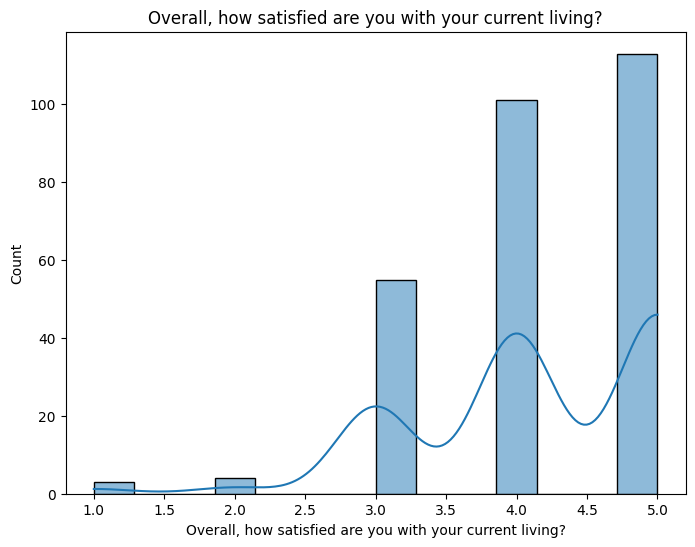

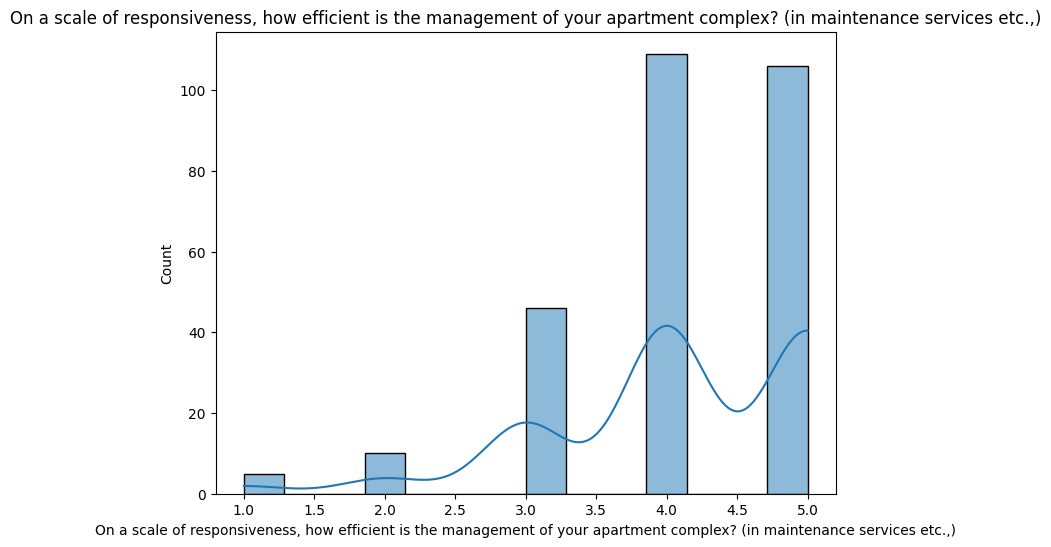

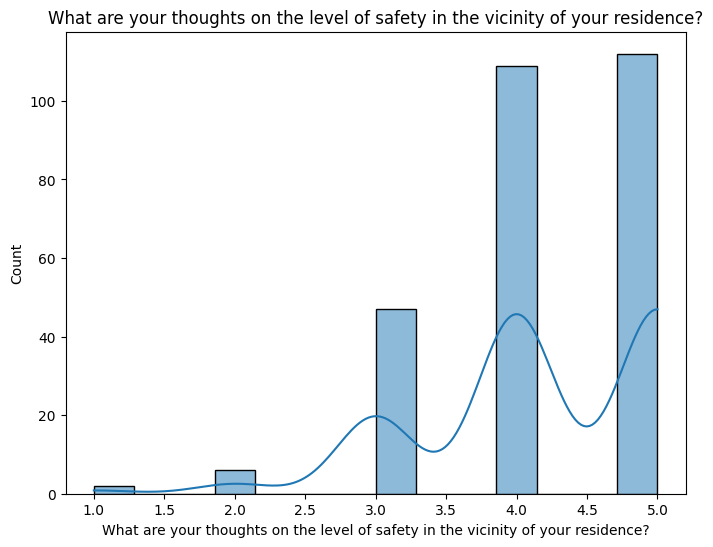

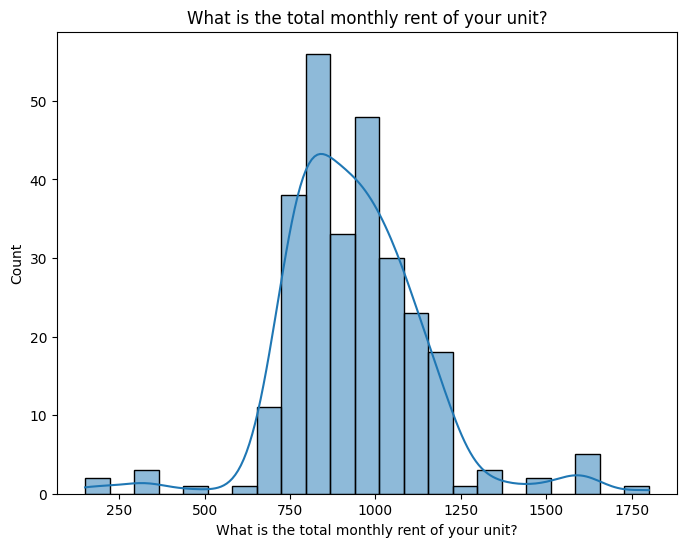

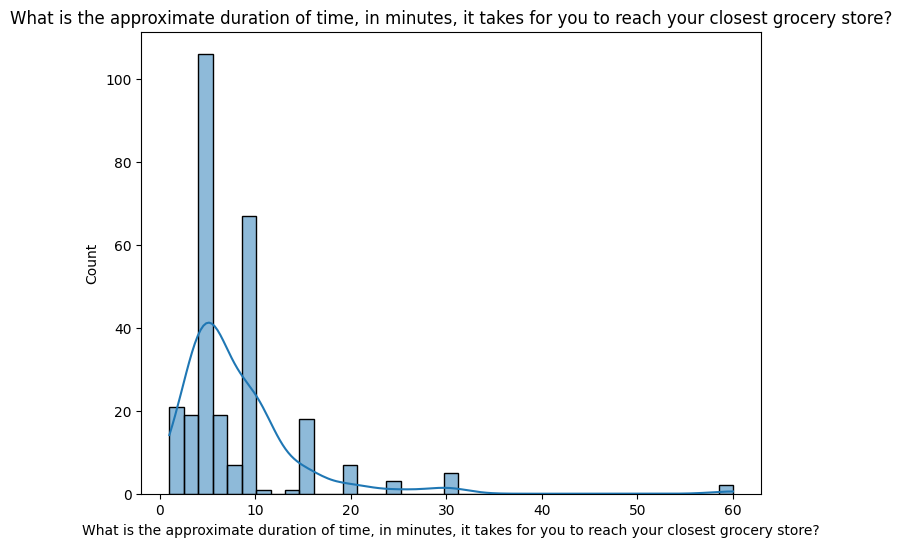

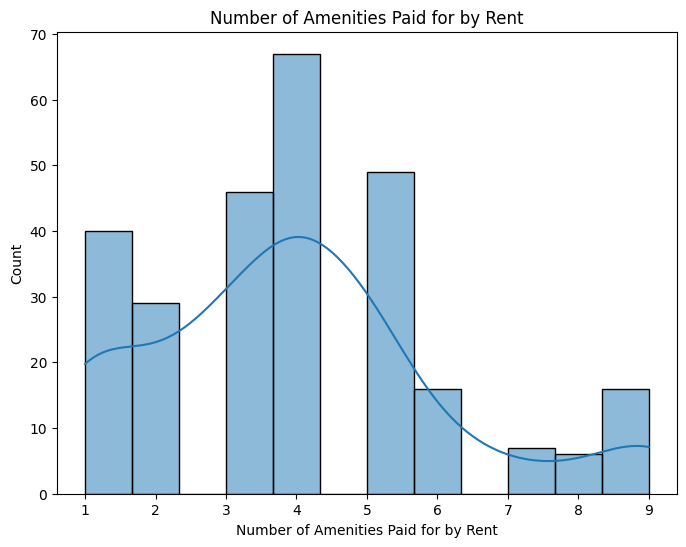

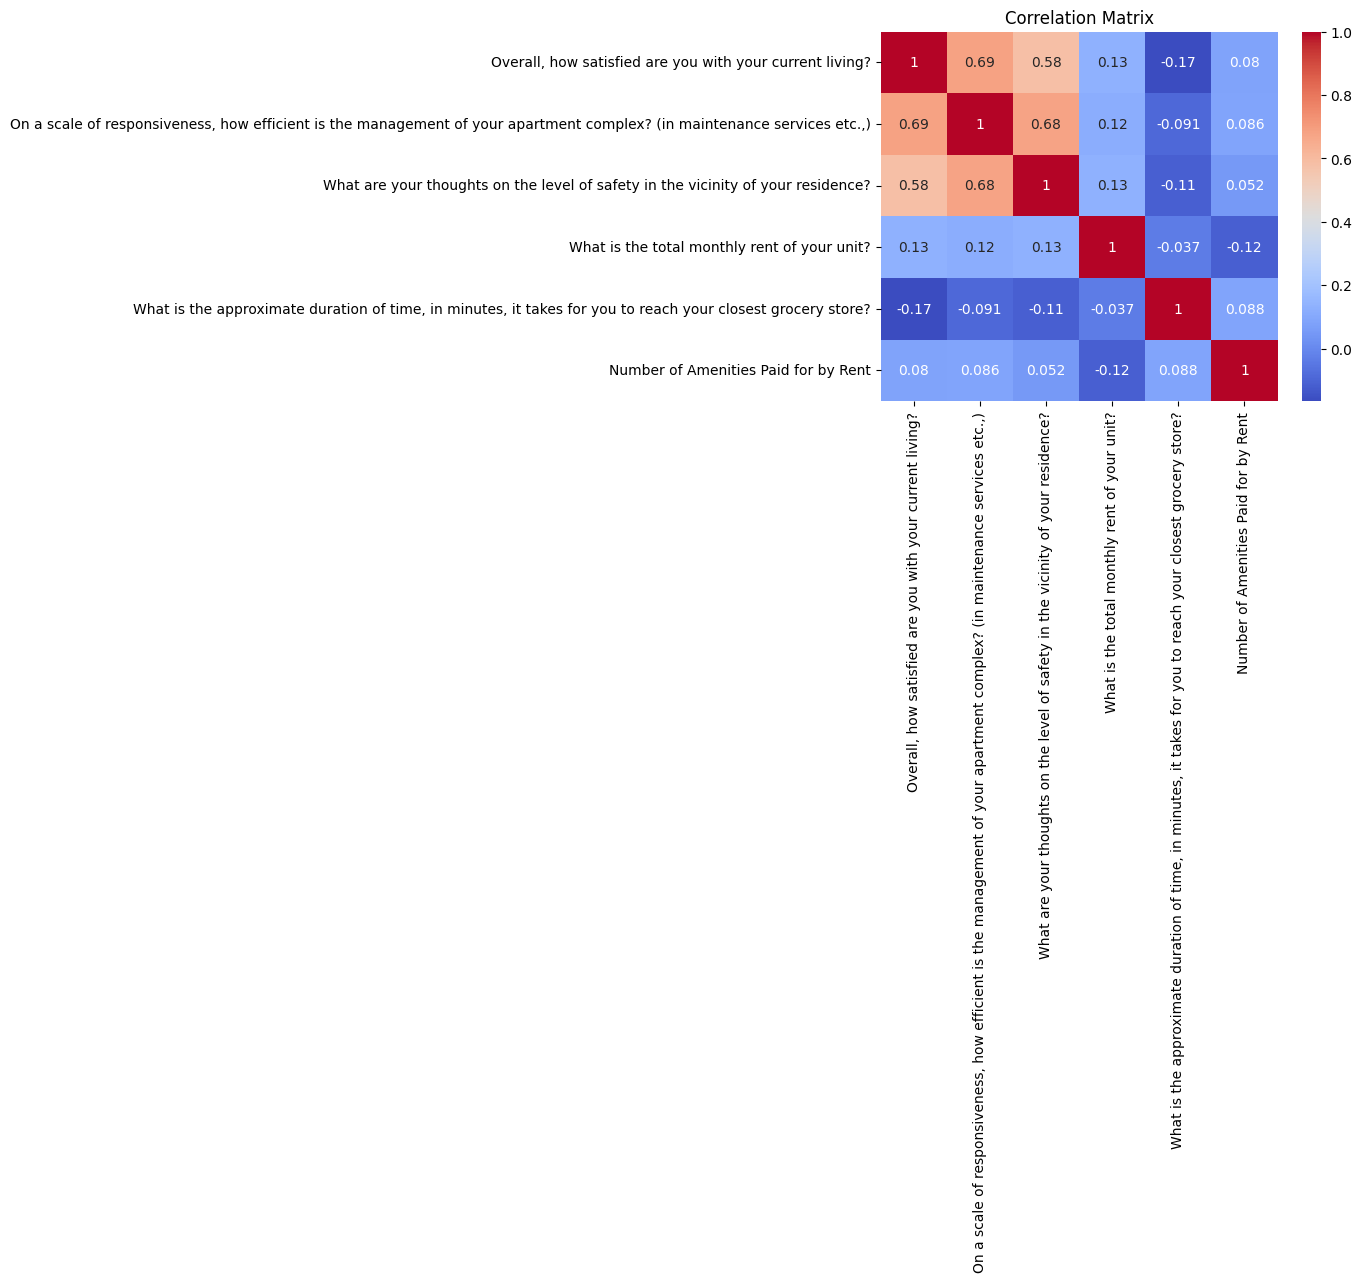

C:\Users\jareds11\AppData\Local\Temp\ipykernel_25176\4107018738.py:94: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for column in df.select_dtypes(include=np.object):


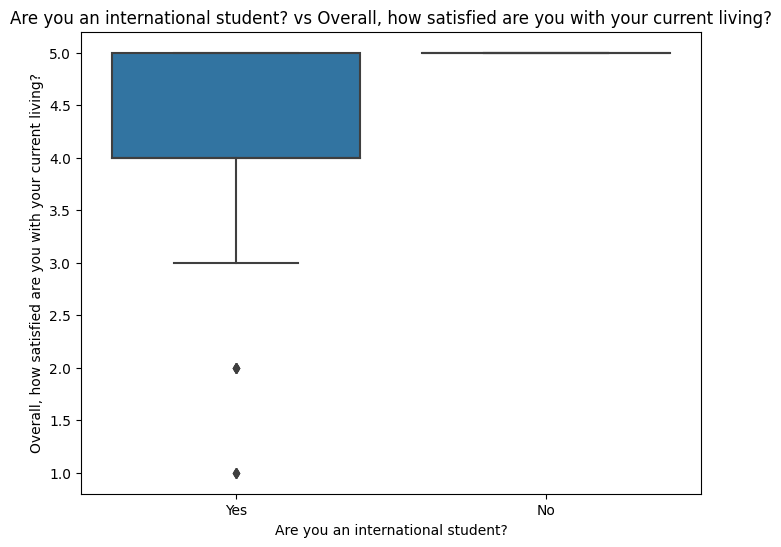

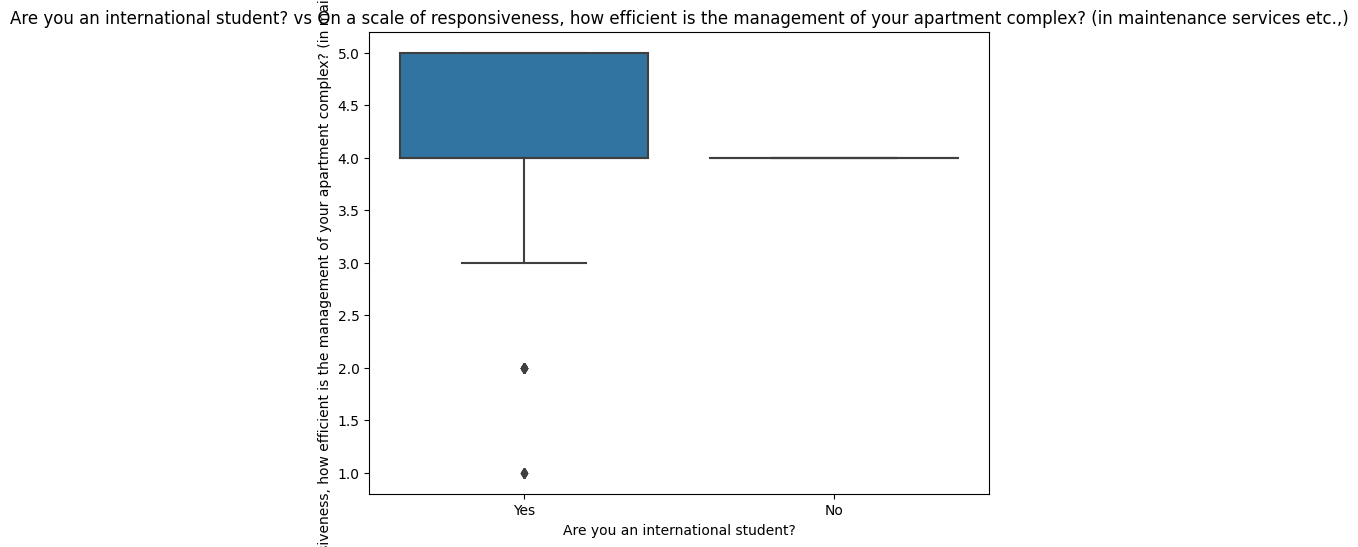

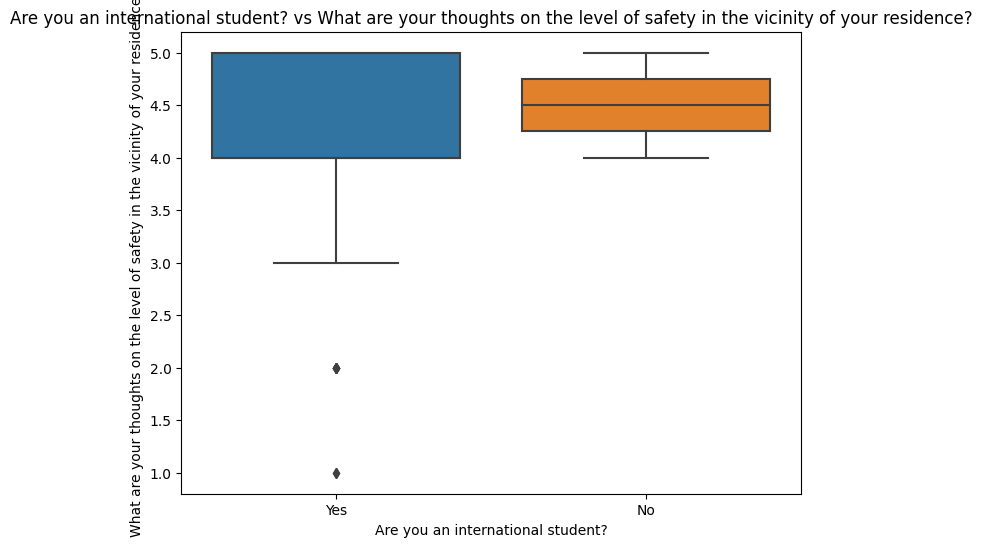

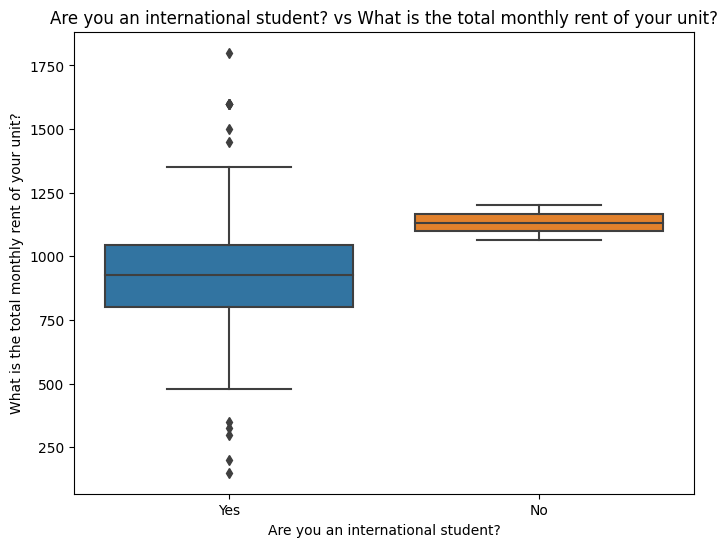

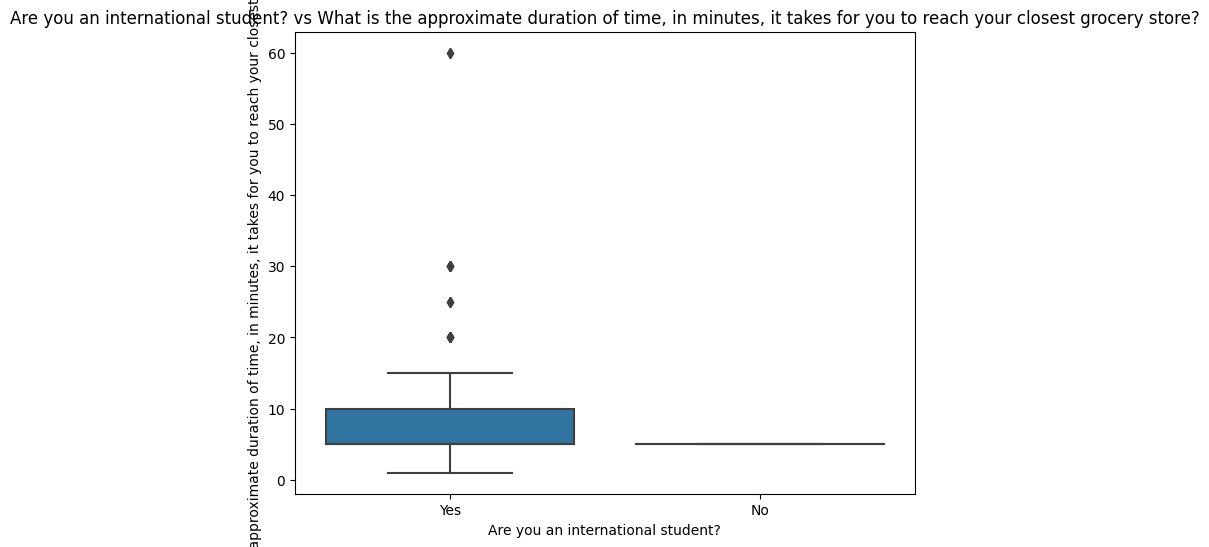

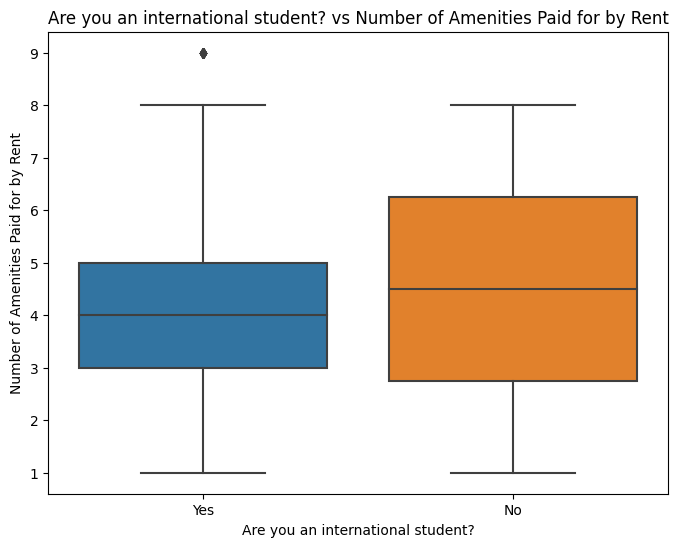

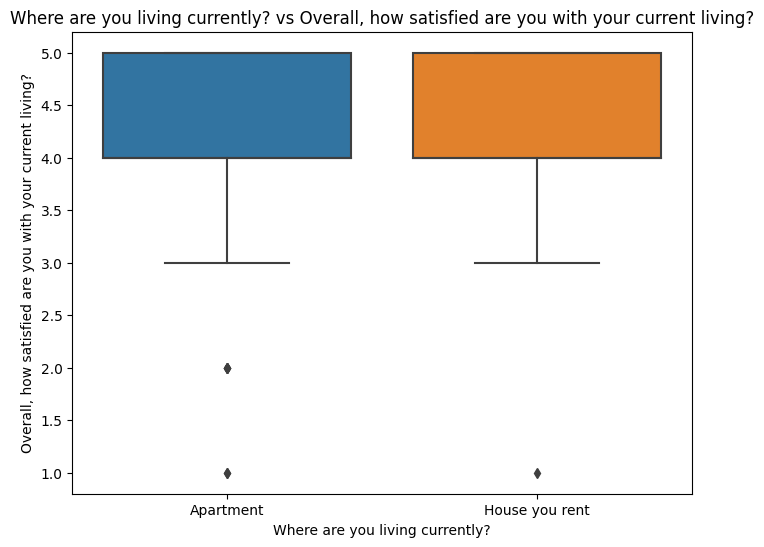

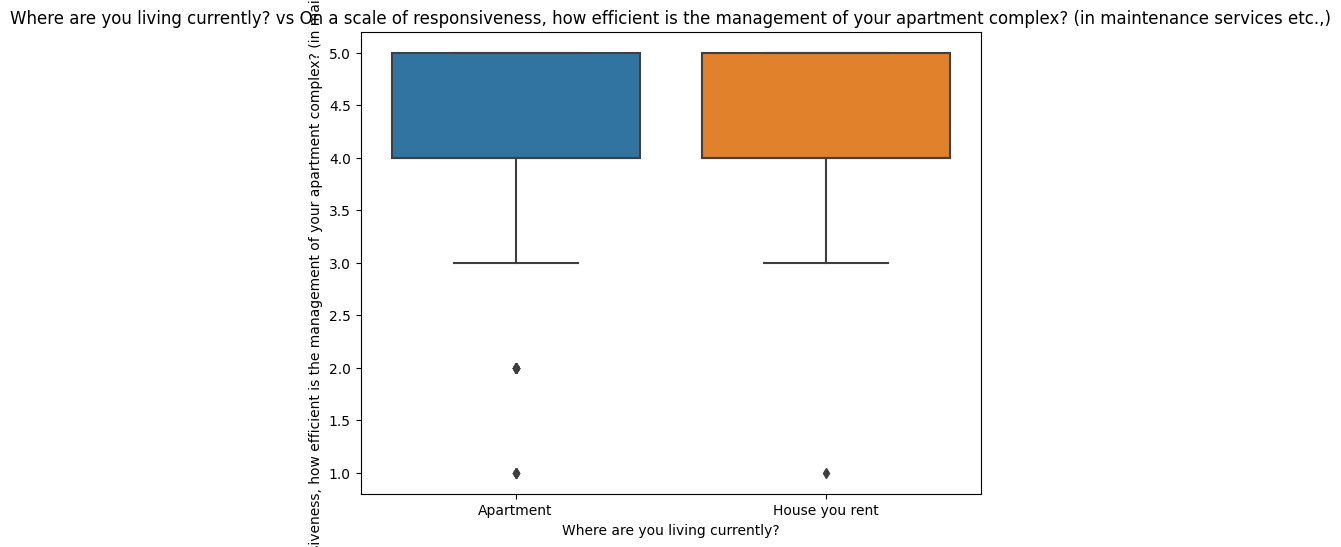

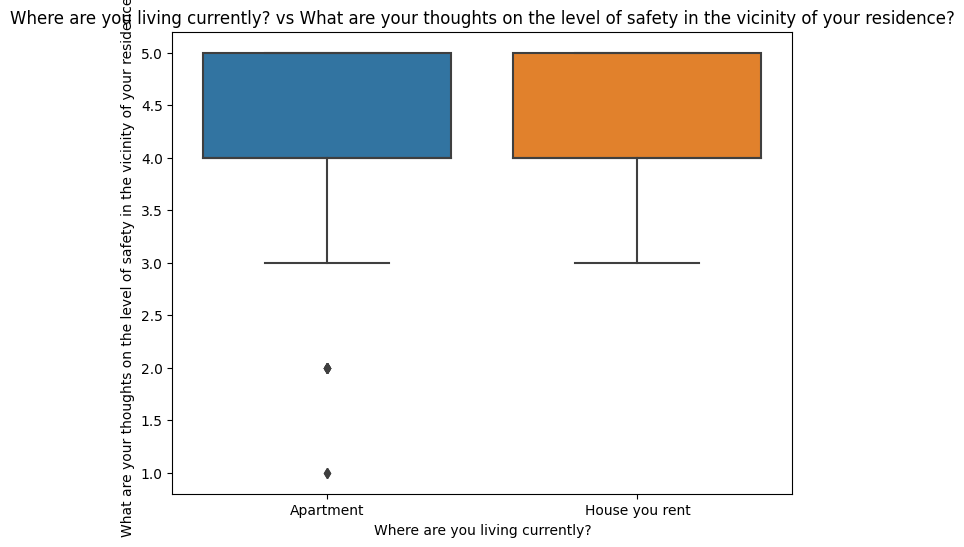

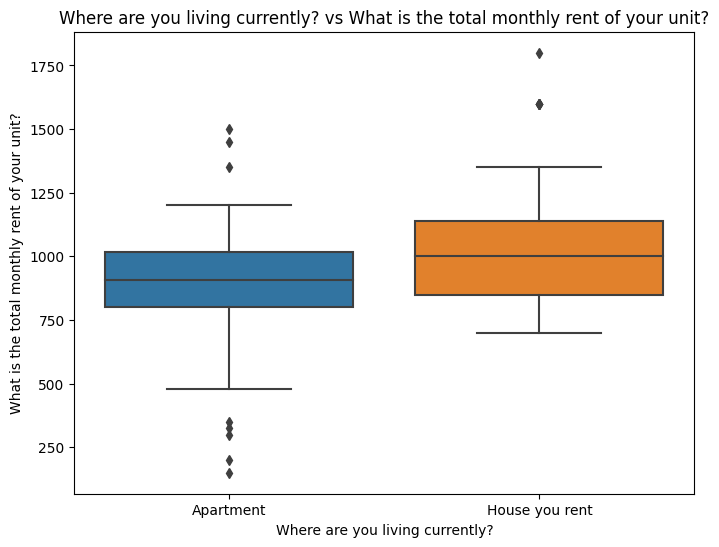

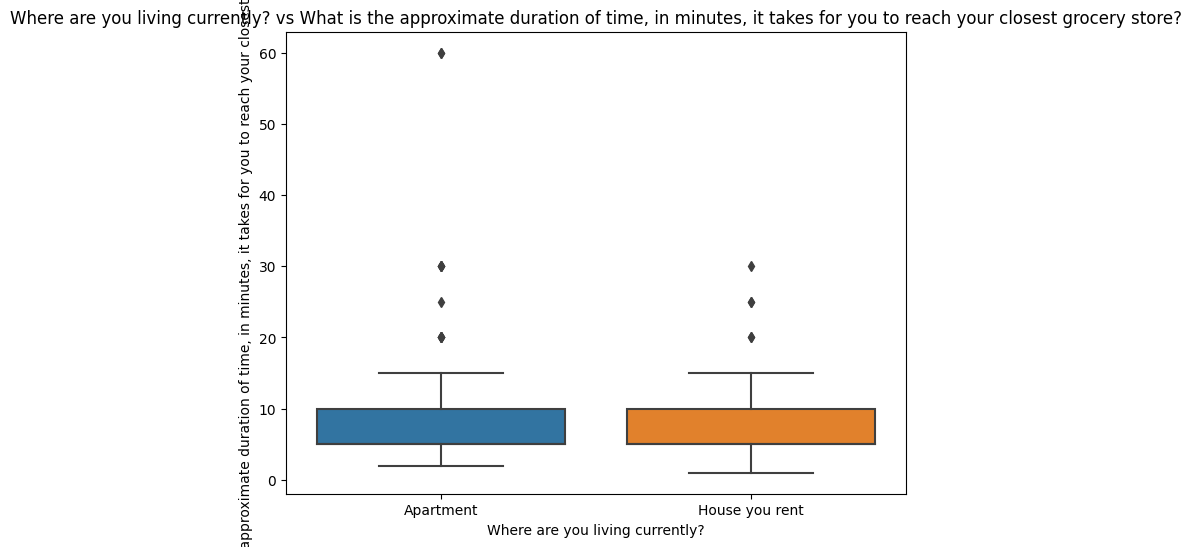

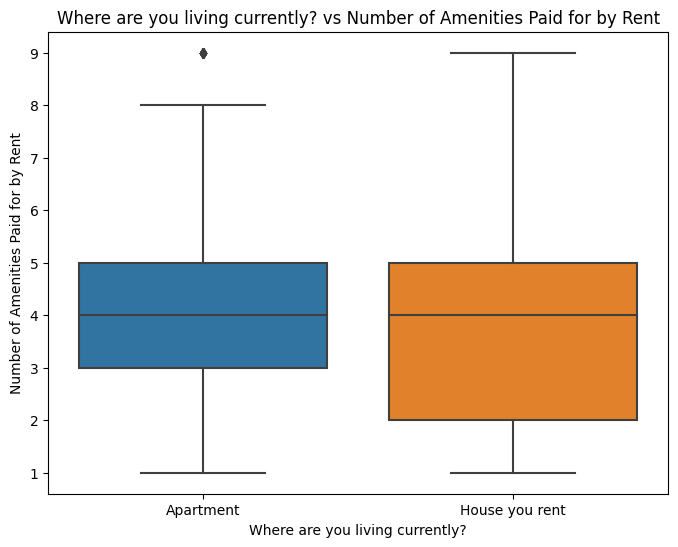

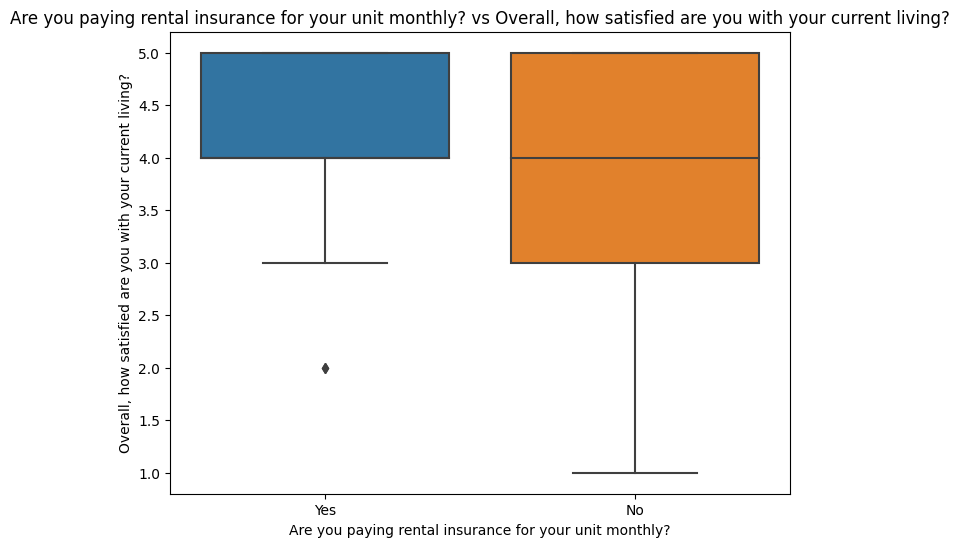

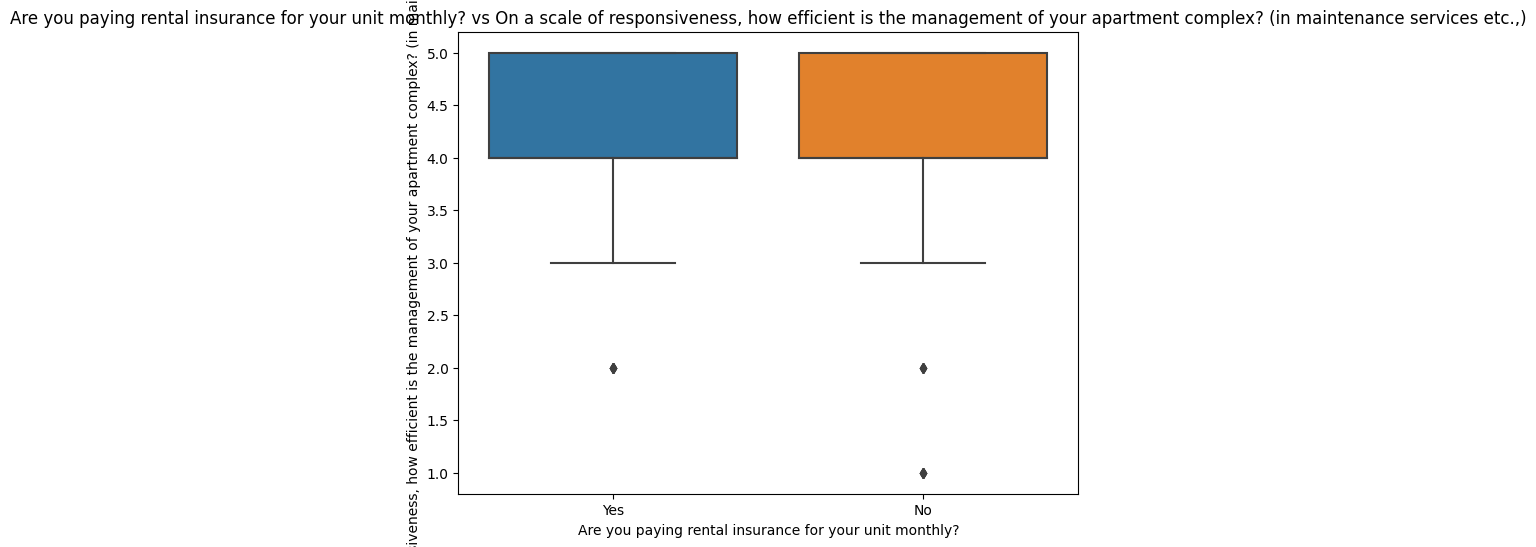

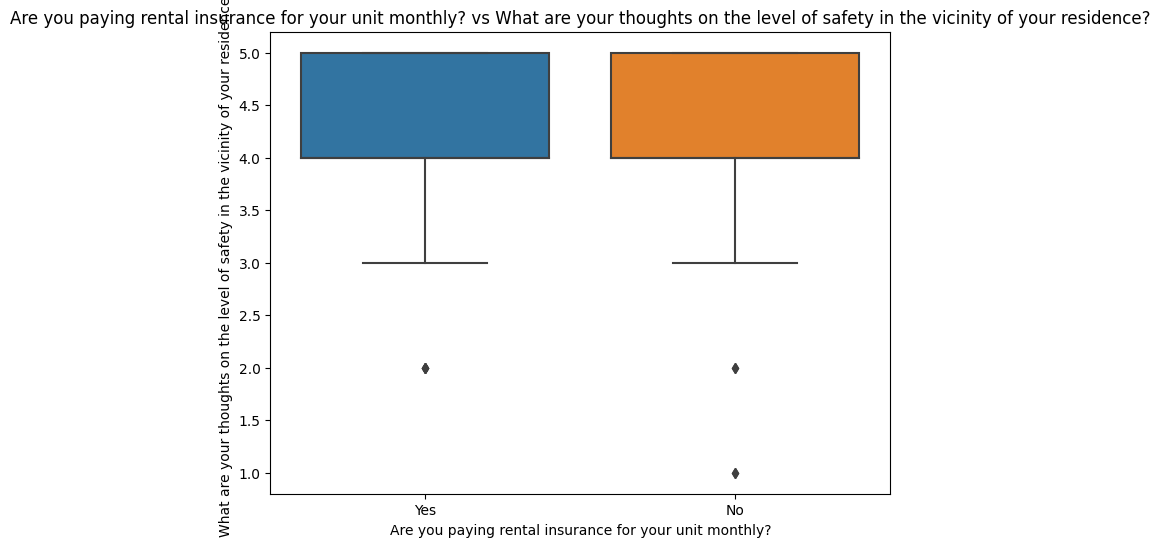

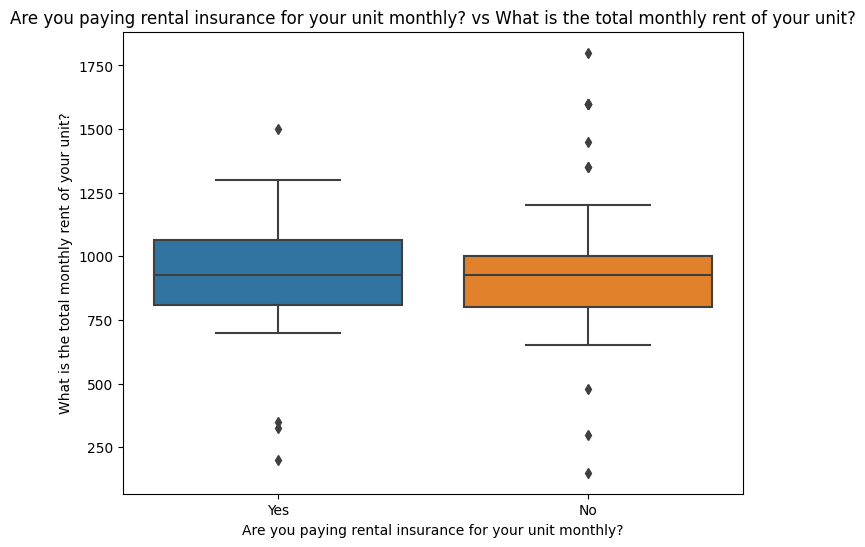

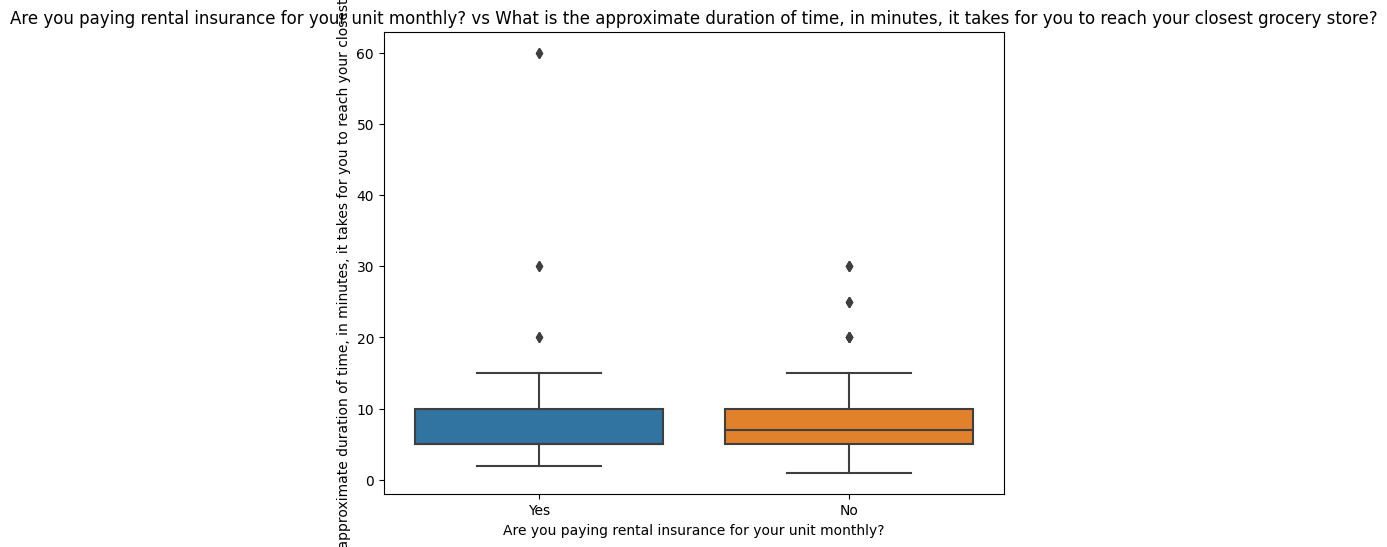

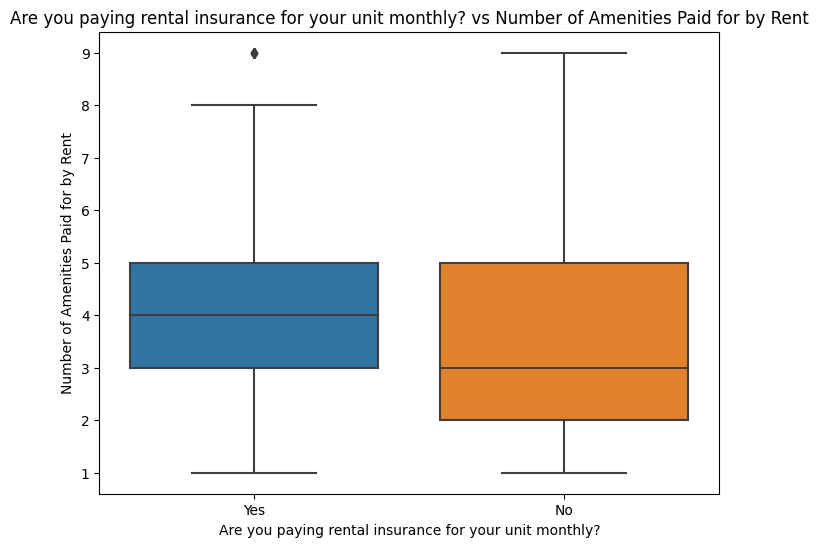

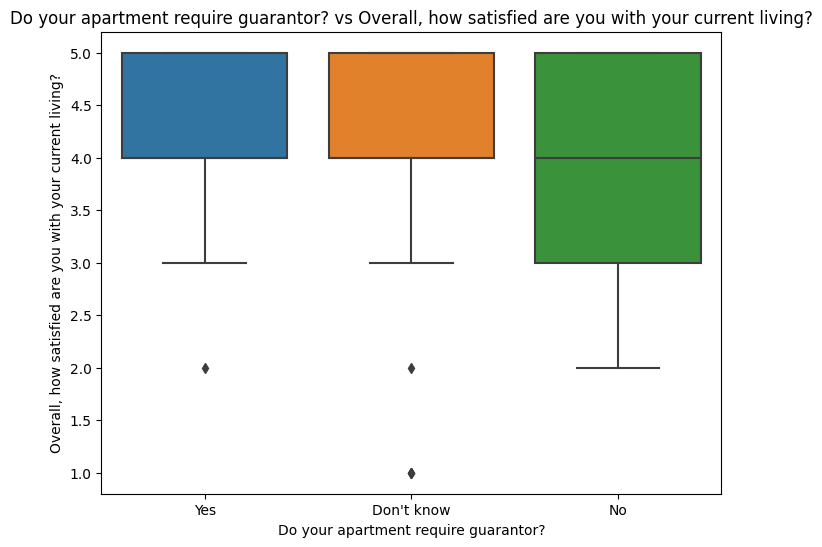

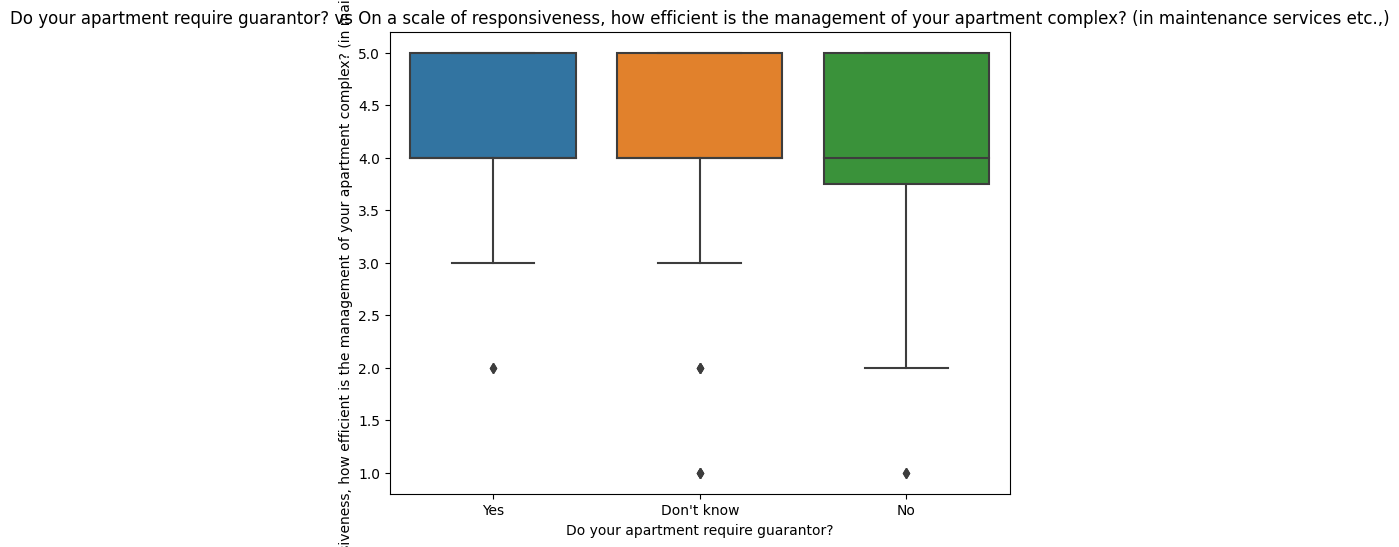

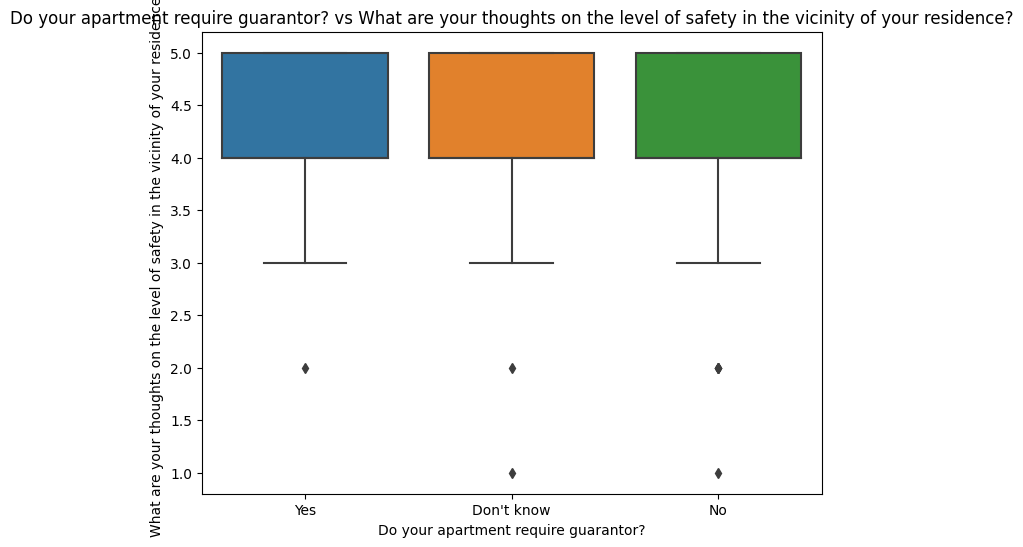

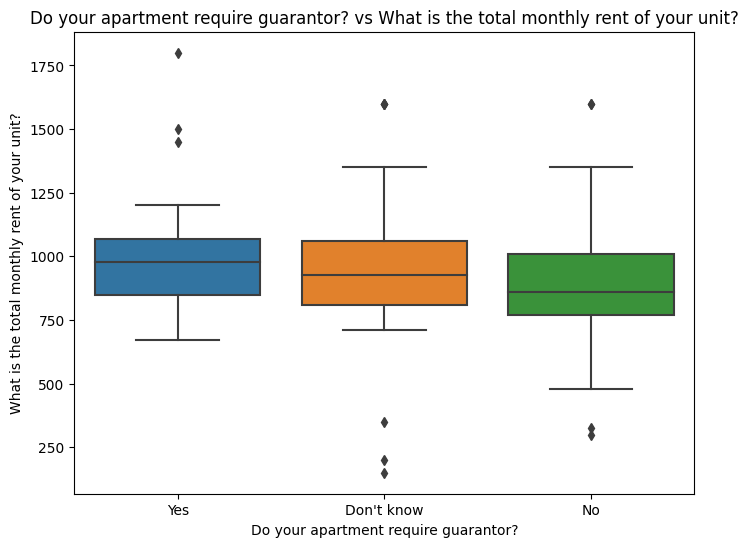

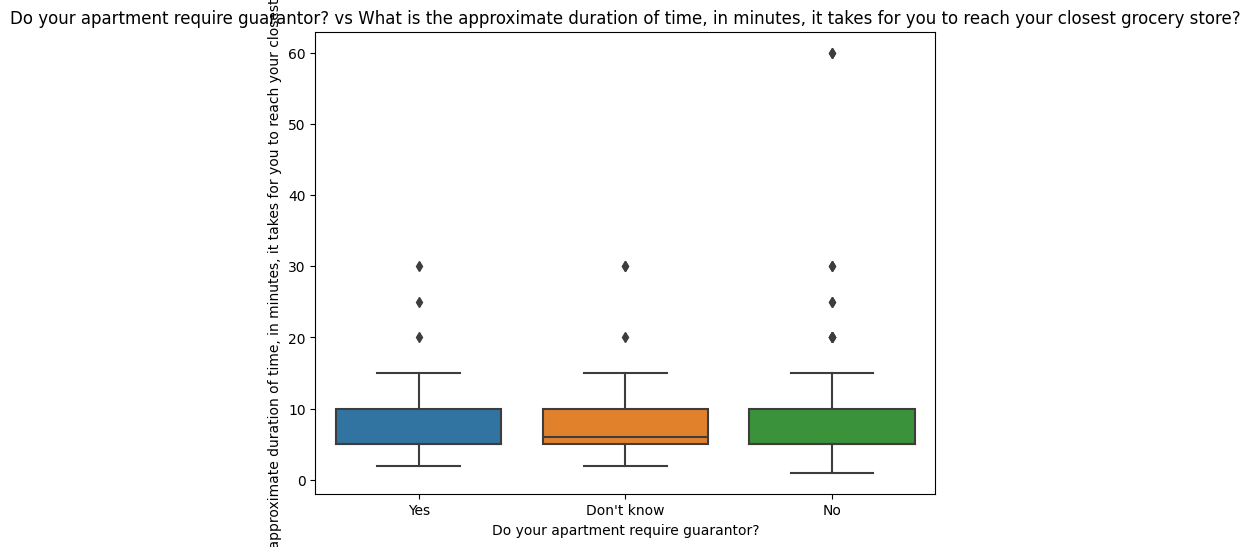

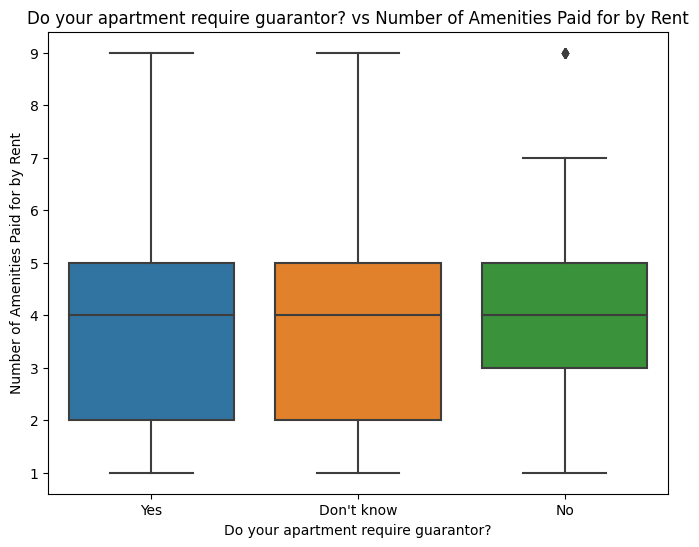

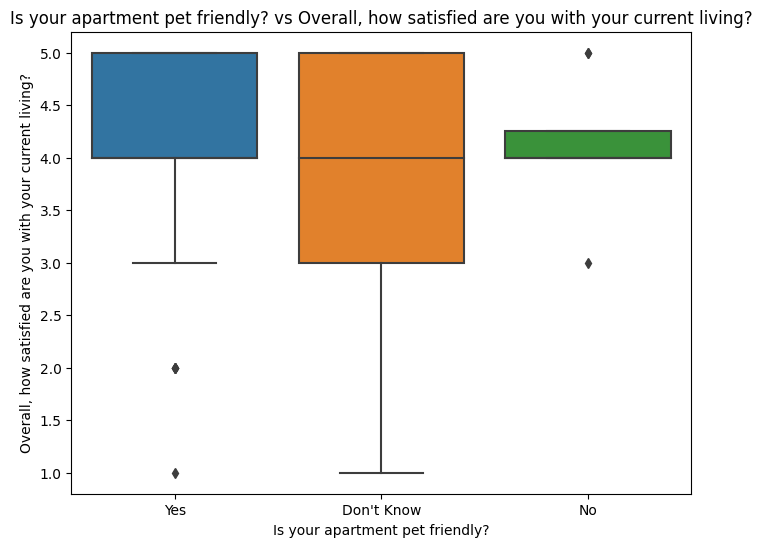

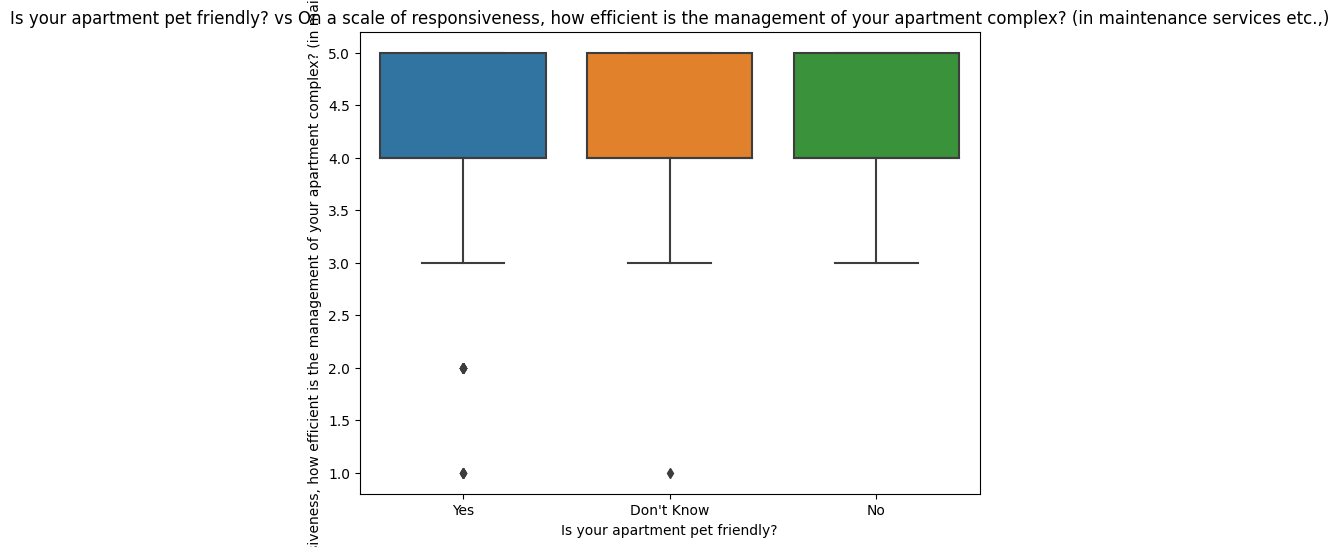

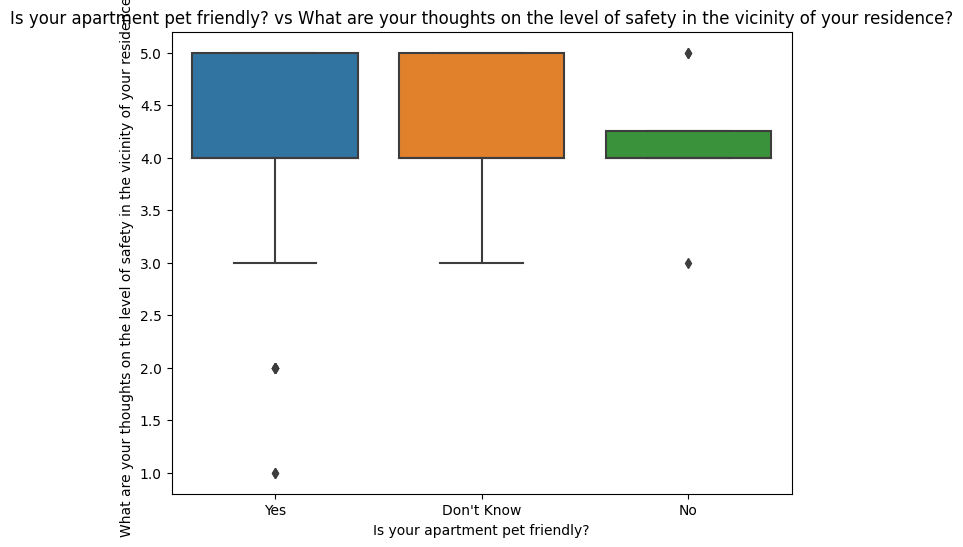

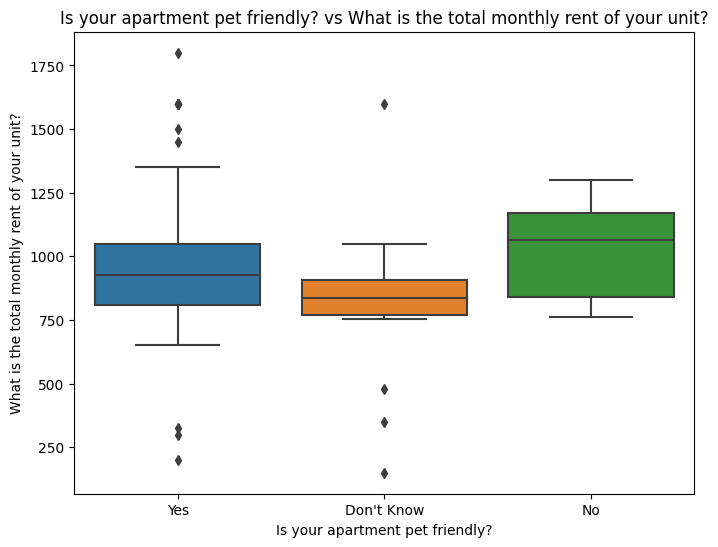

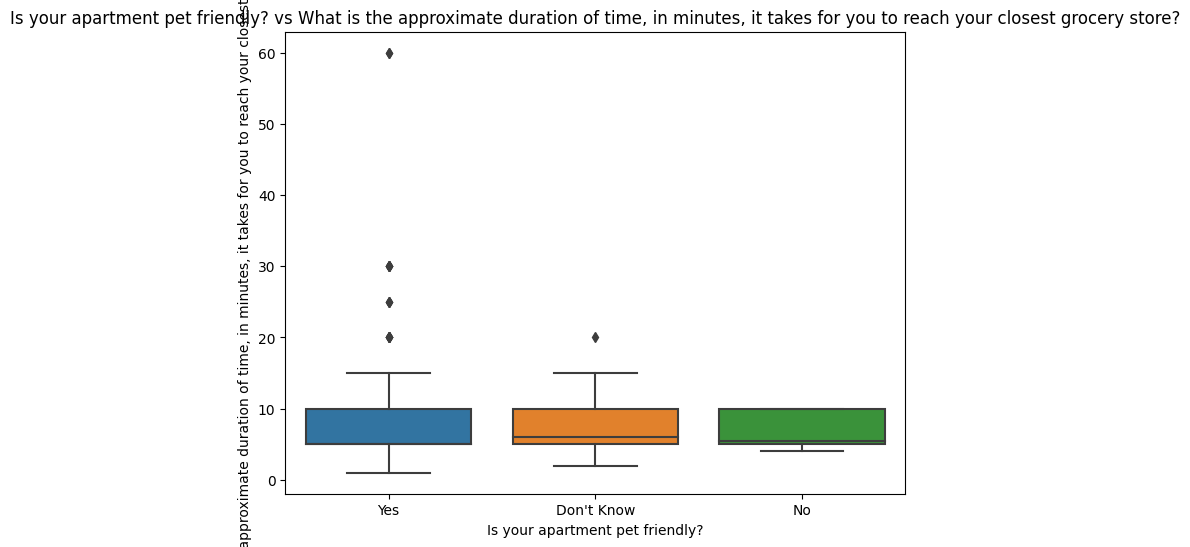

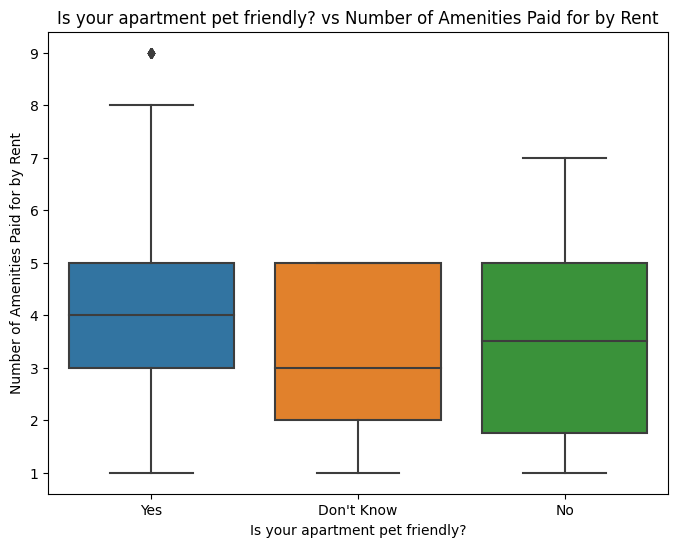

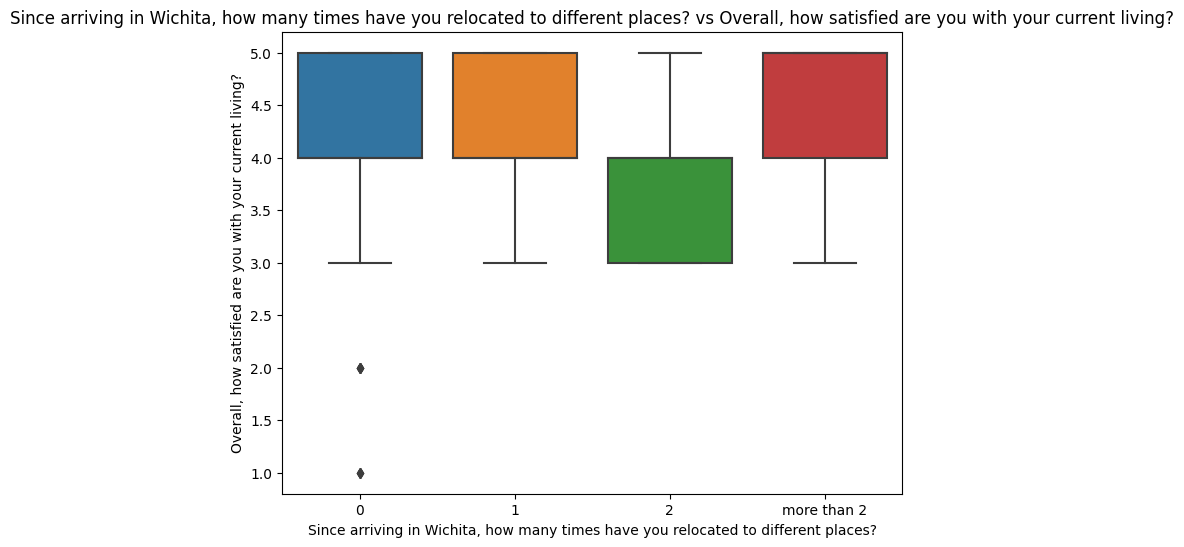

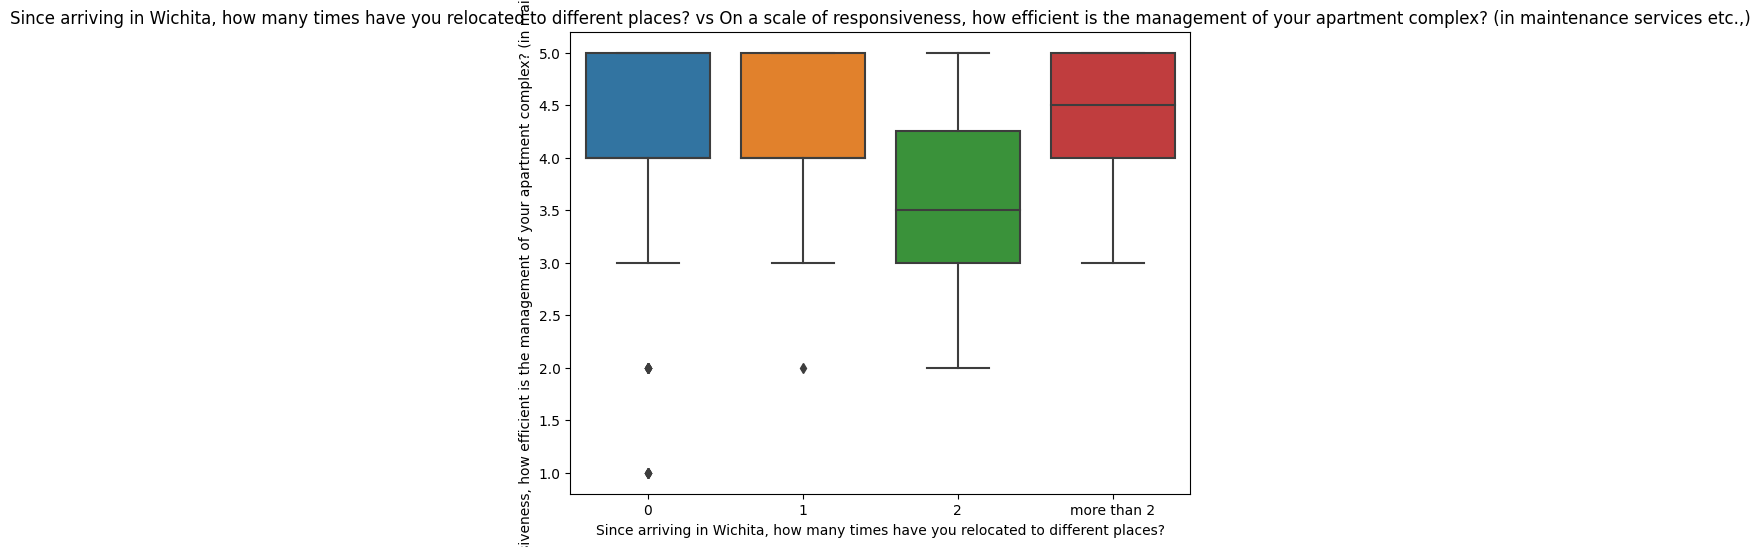

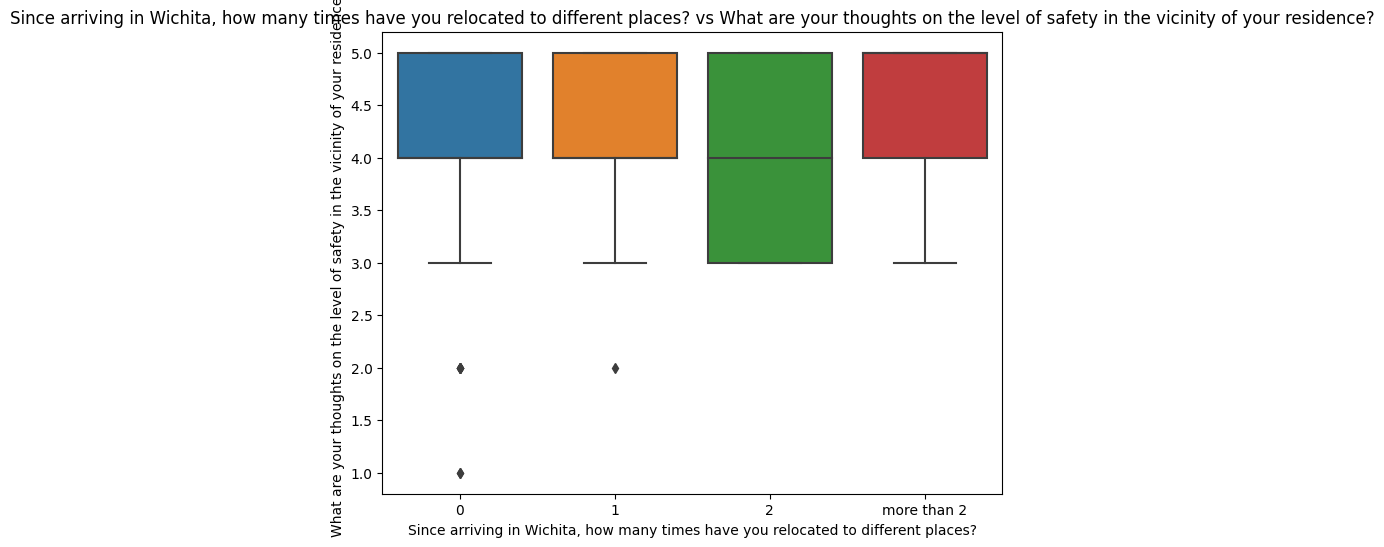

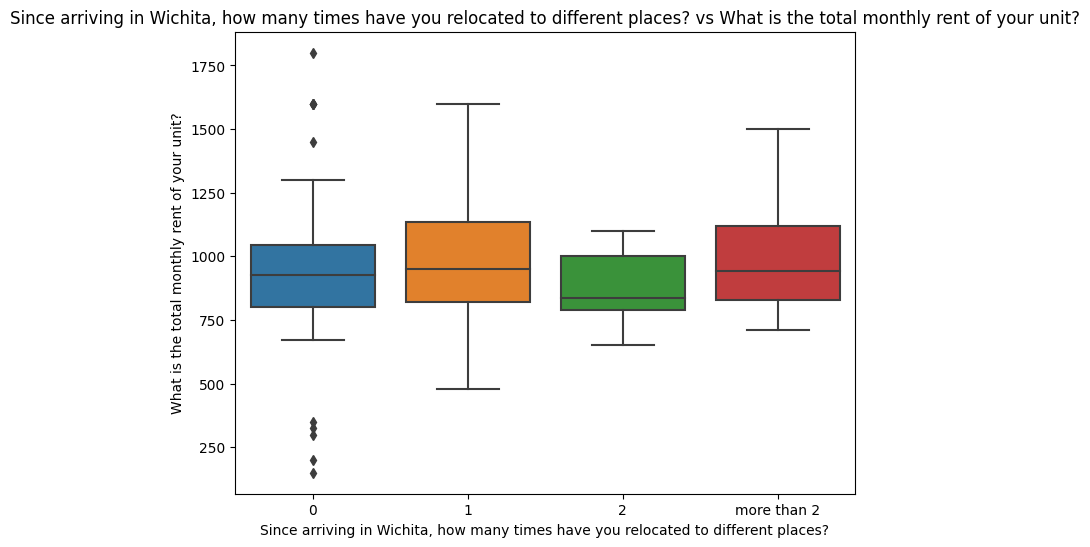

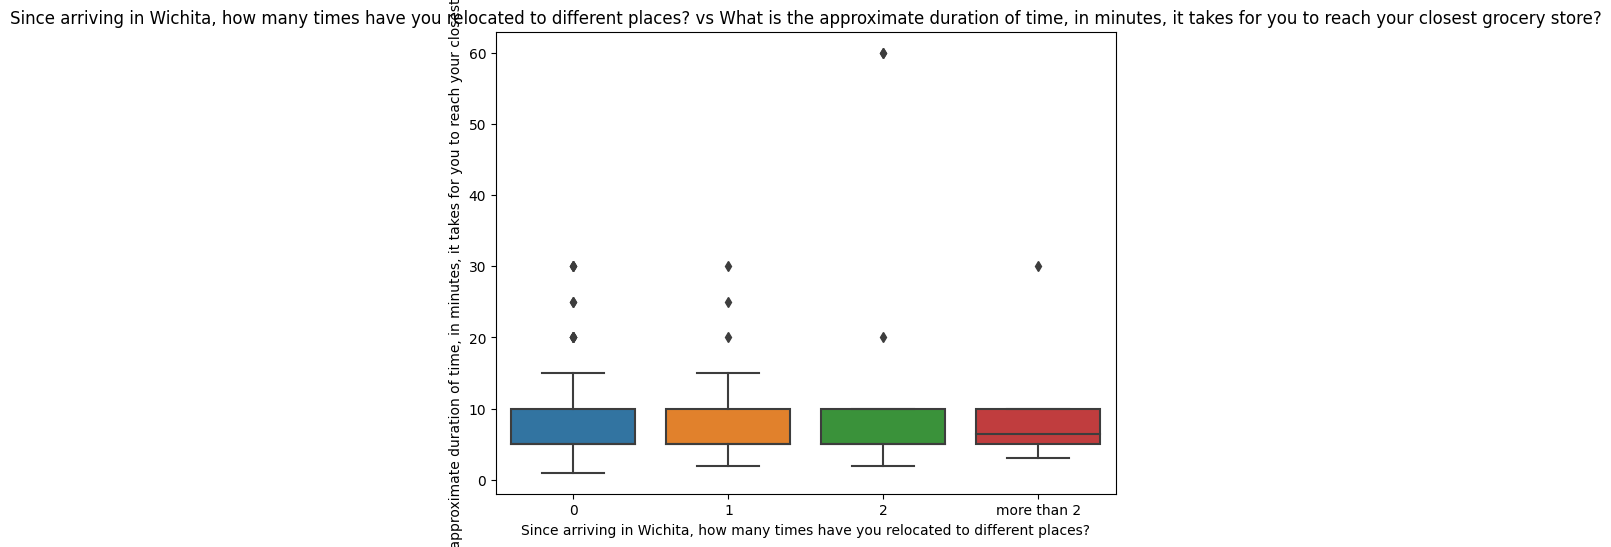

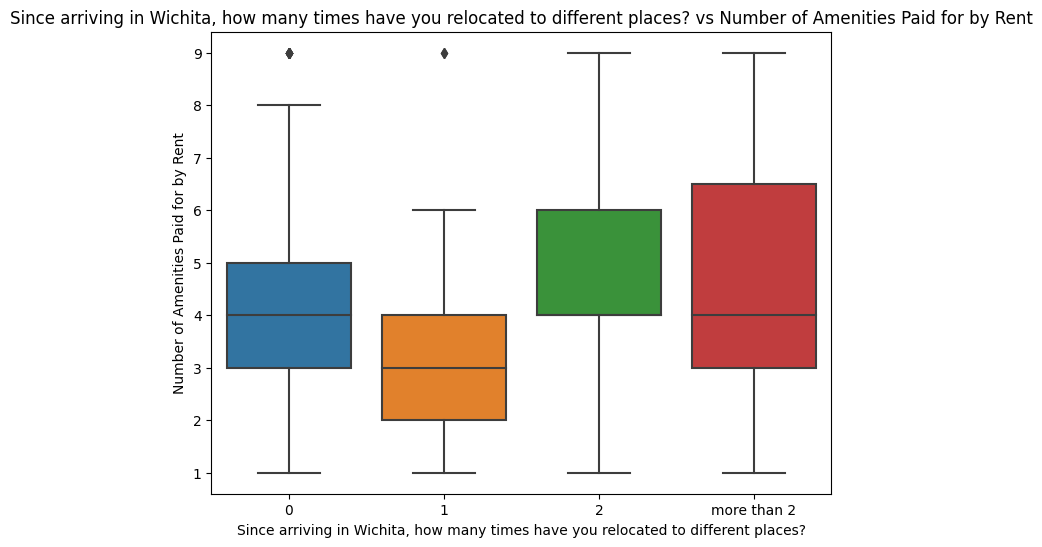

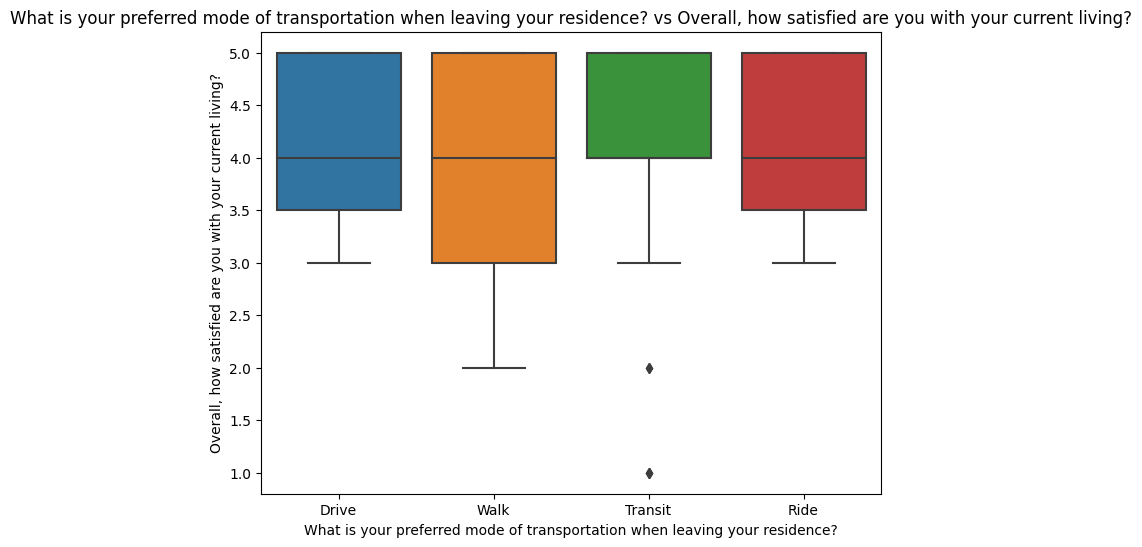

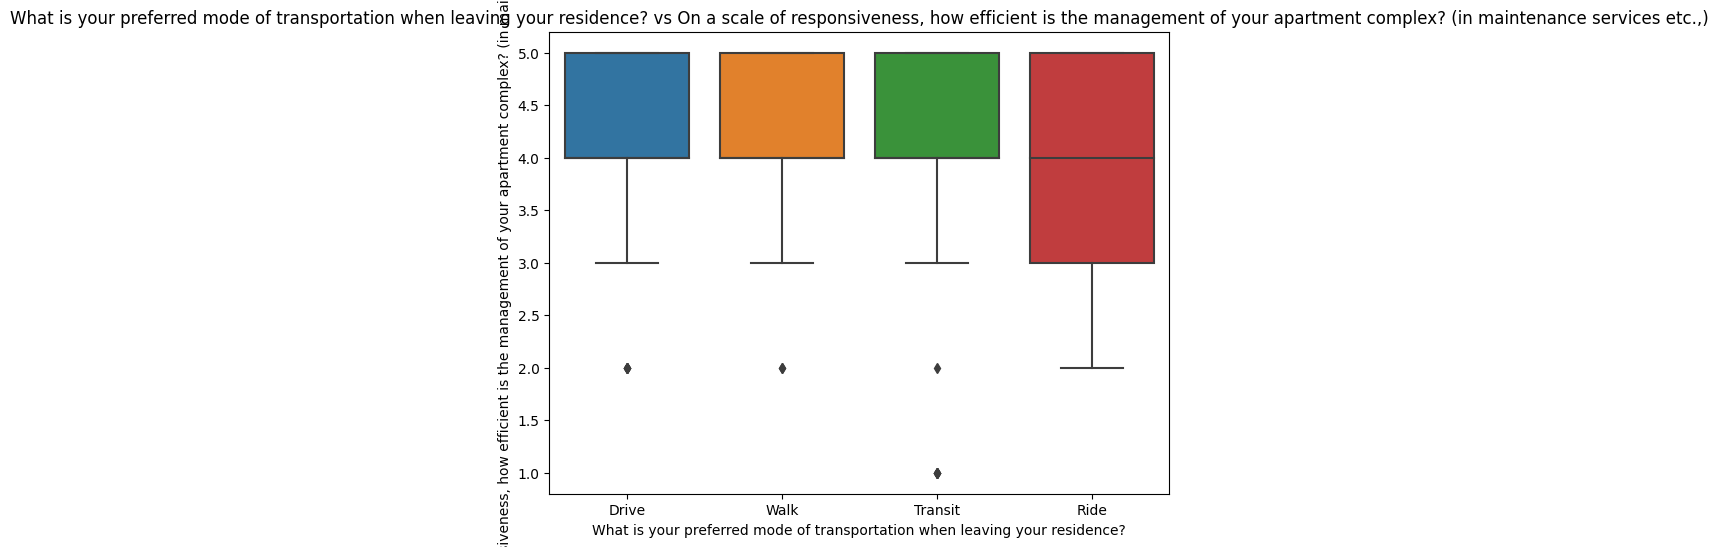

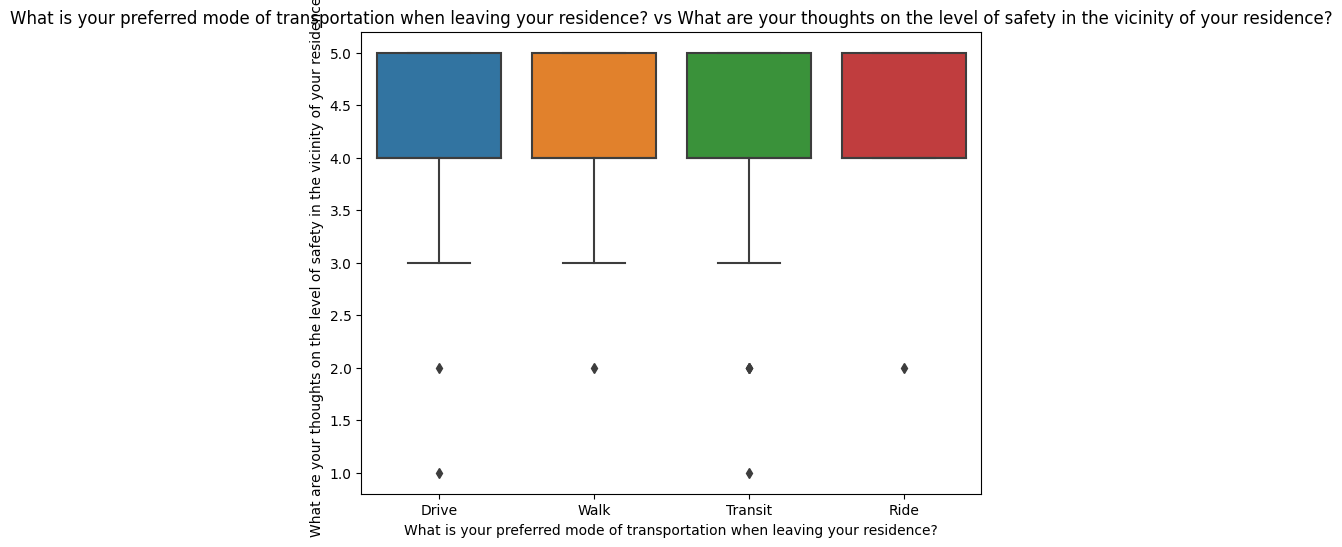

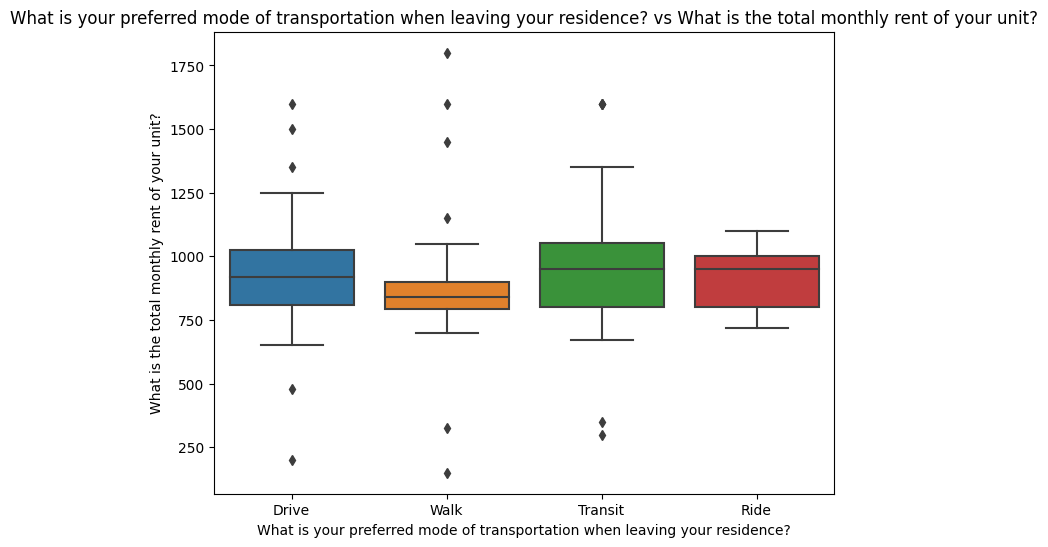

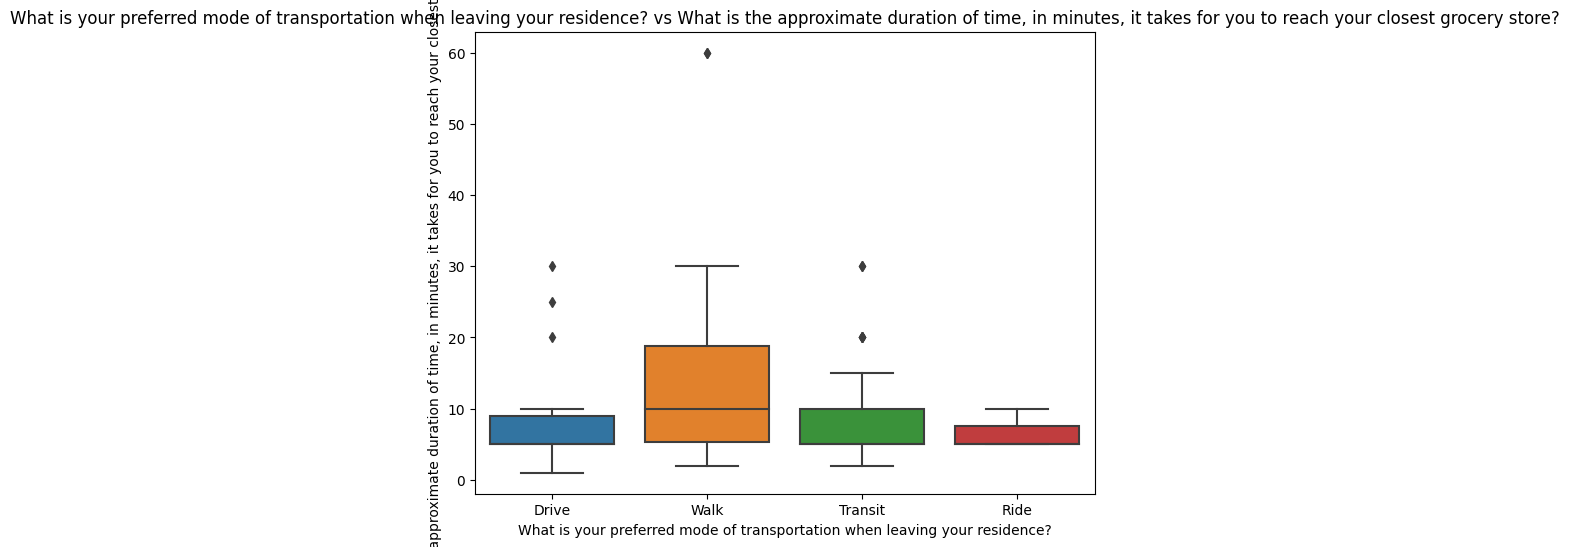

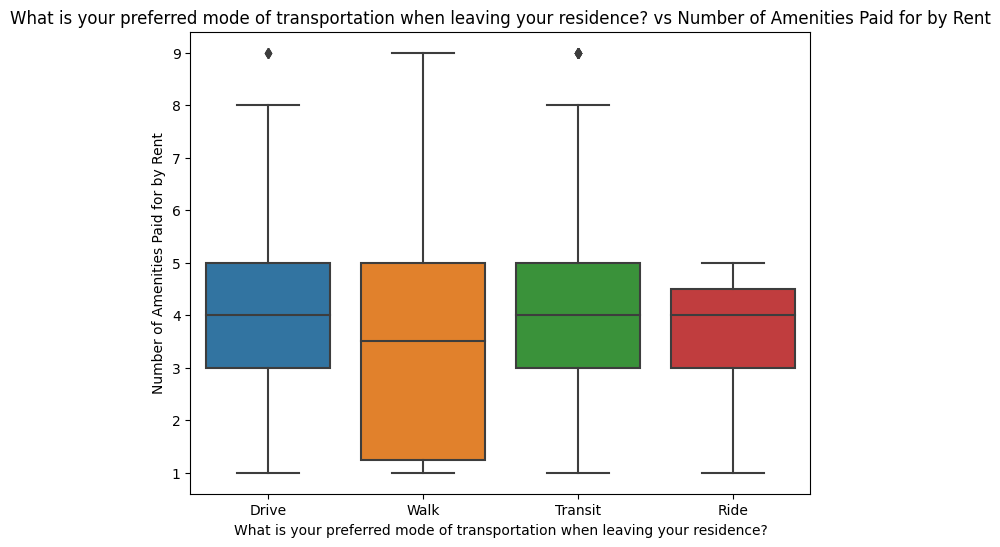

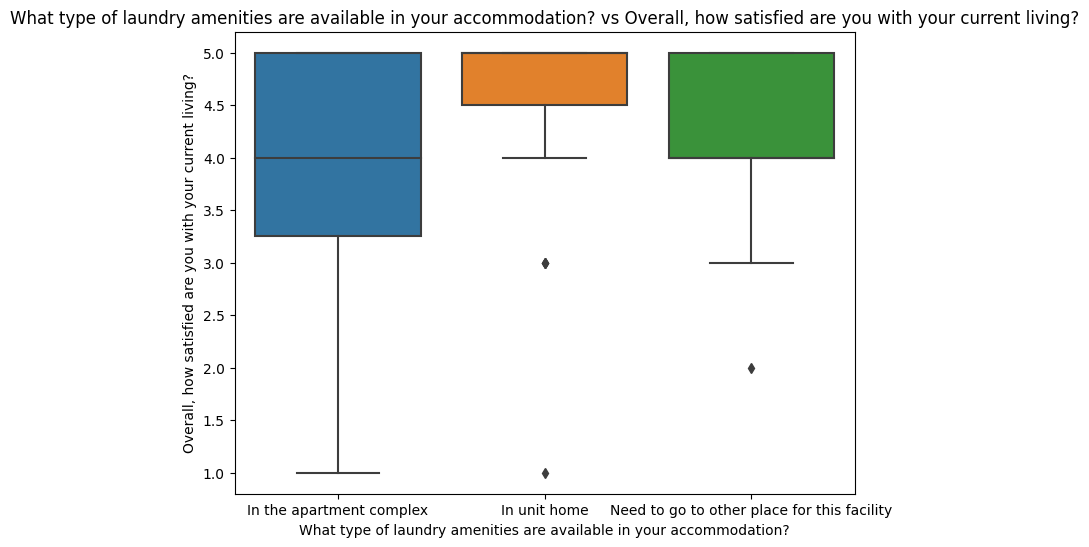

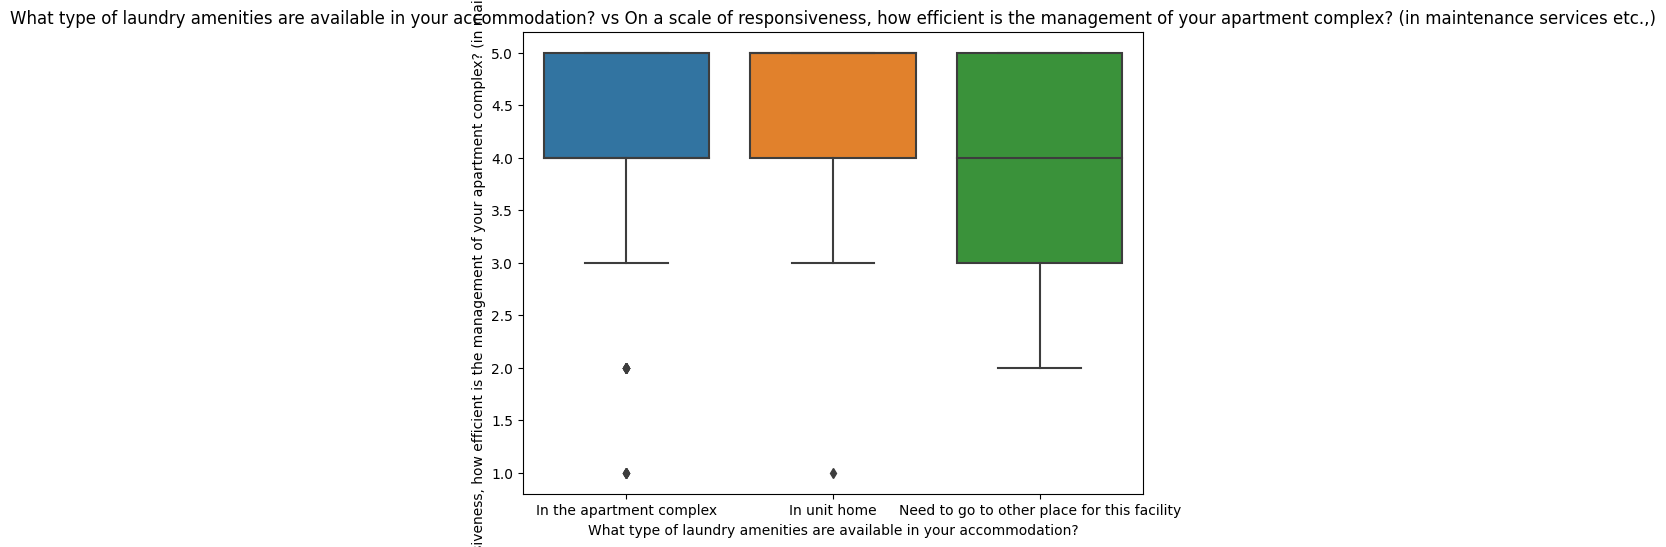

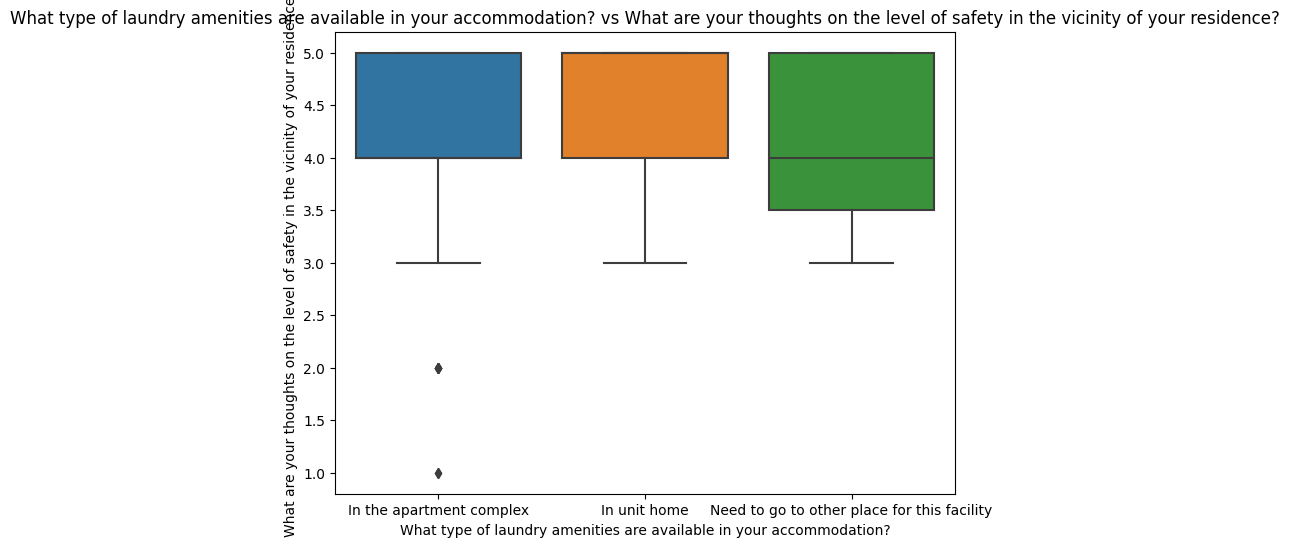

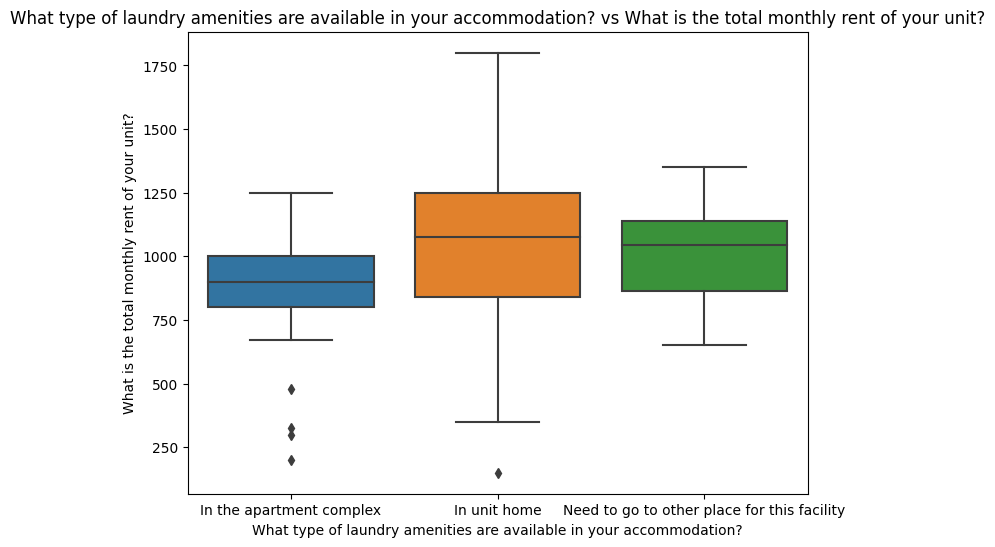

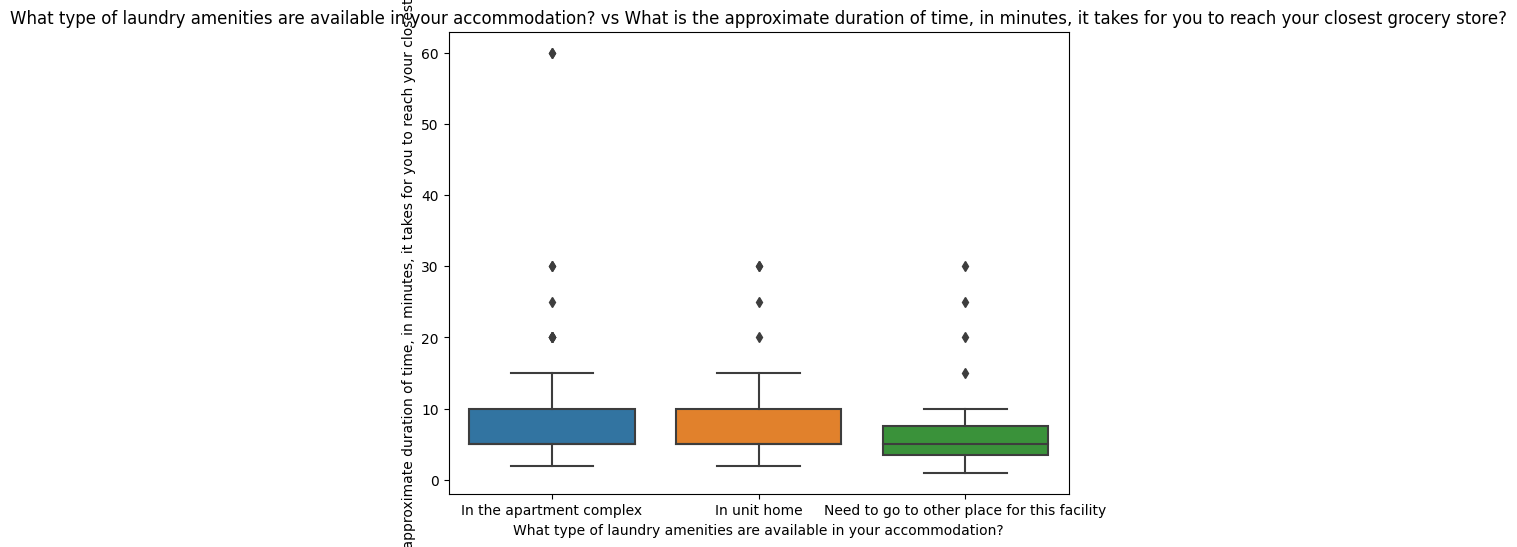

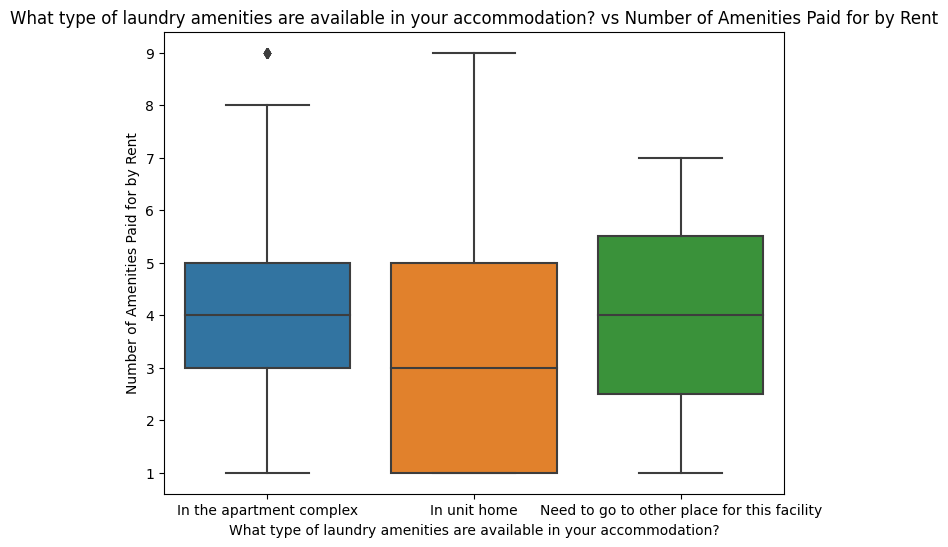

C:\Users\jareds11\AppData\Local\Temp\ipykernel_25176\4107018738.py:103: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for column in df.select_dtypes(include=np.object):


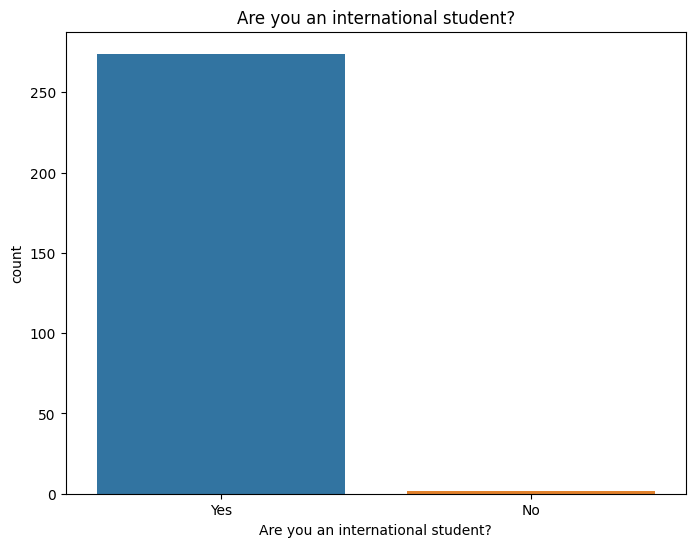

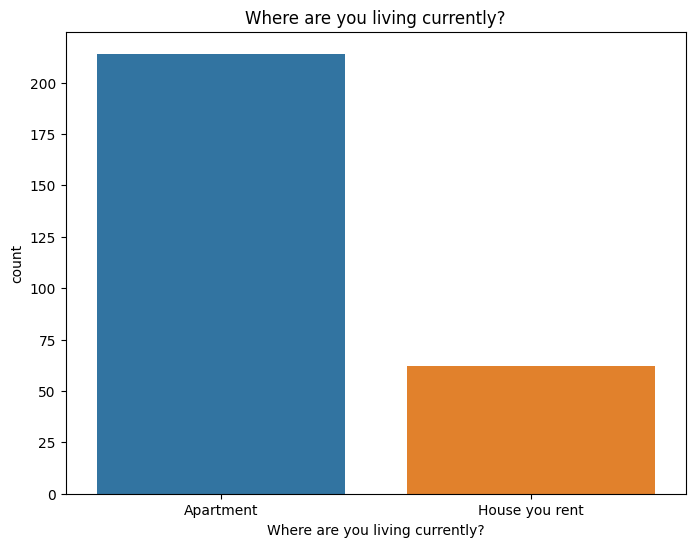

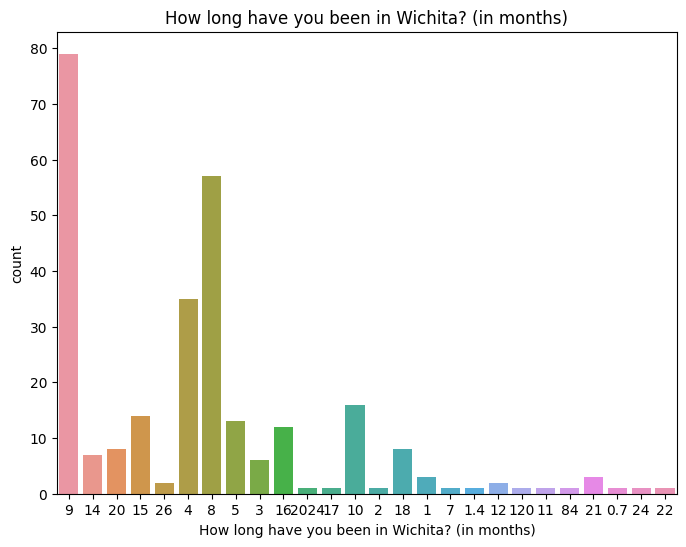

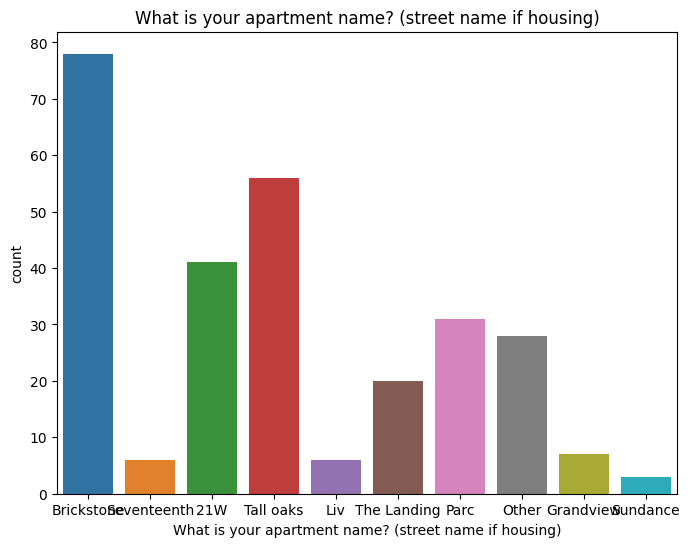

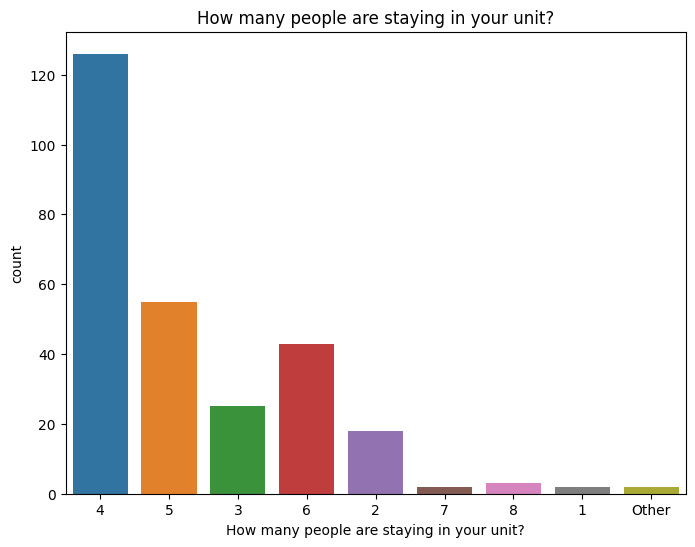

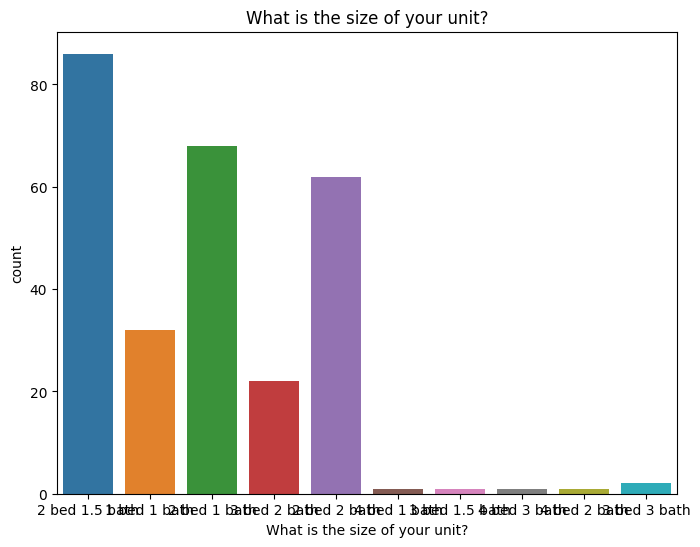

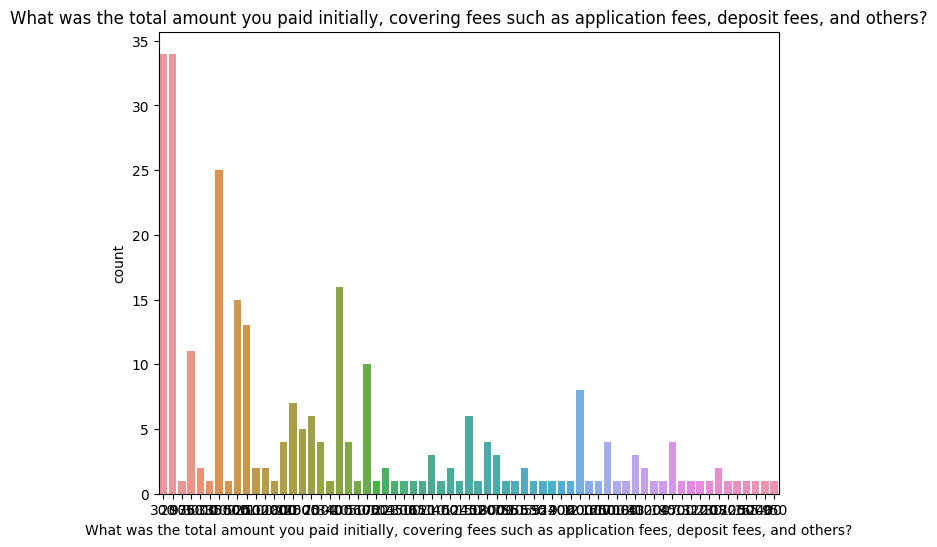

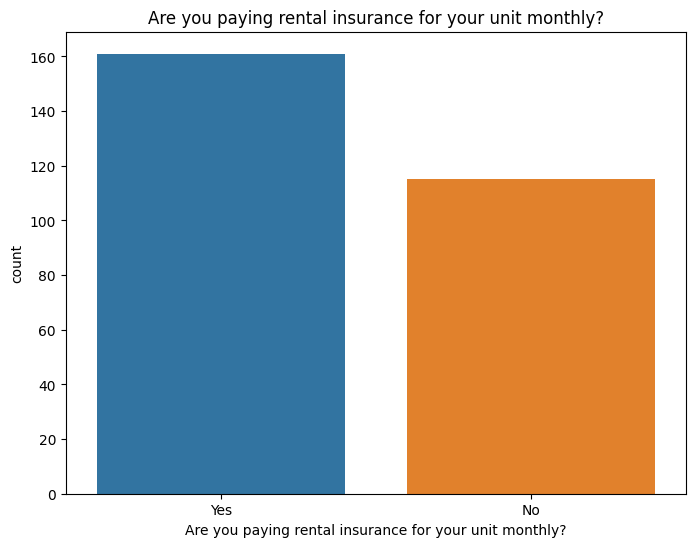

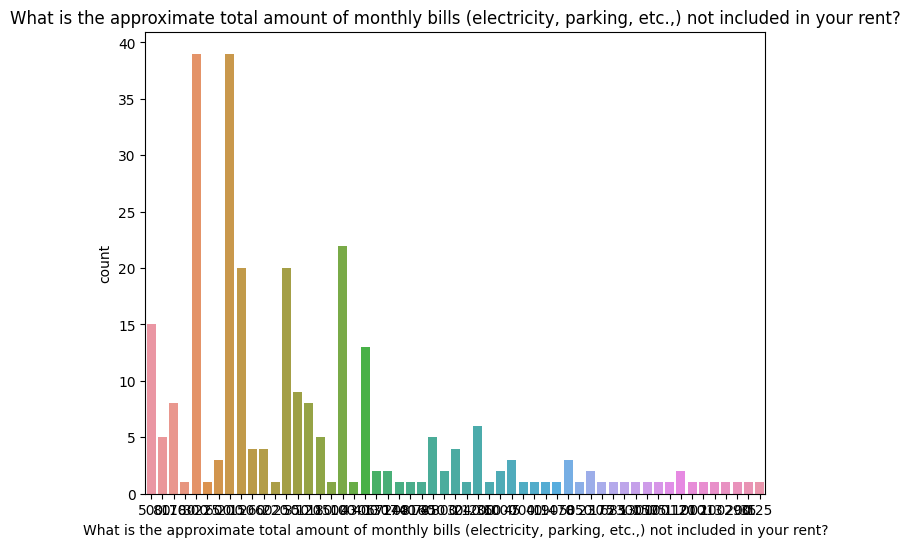

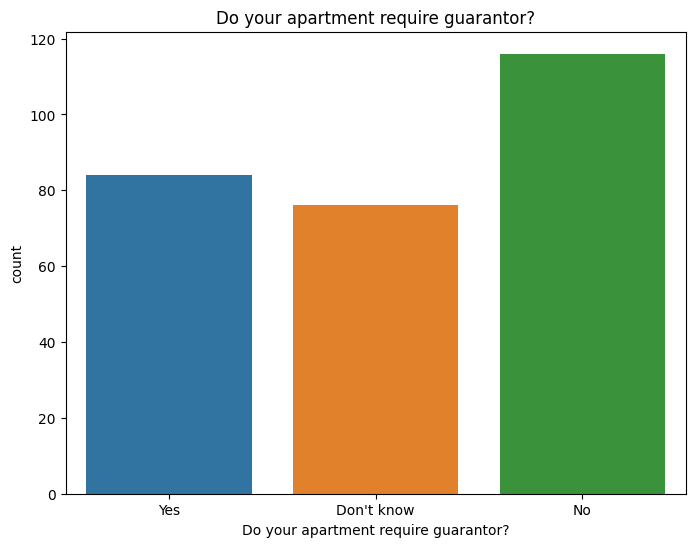

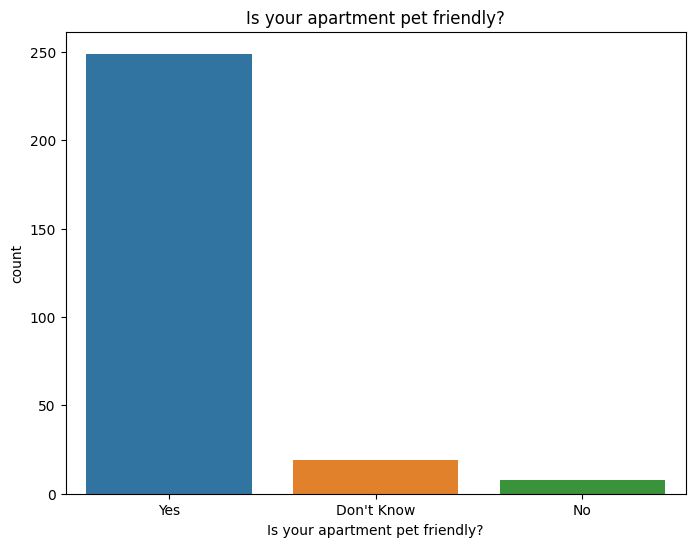

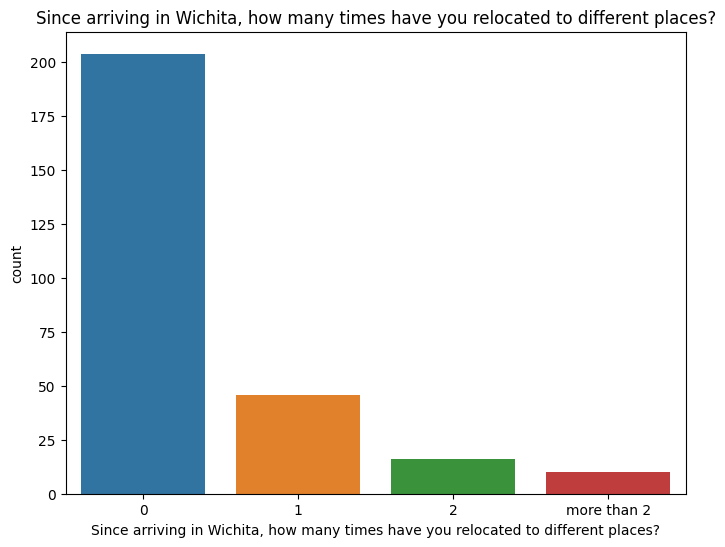

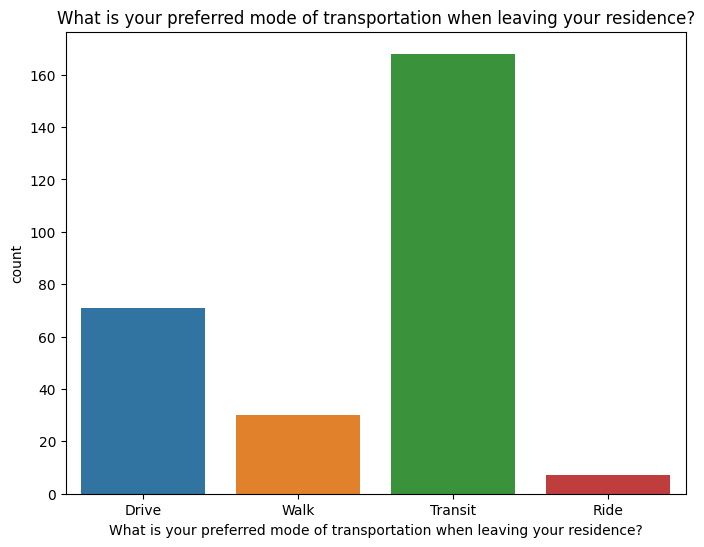

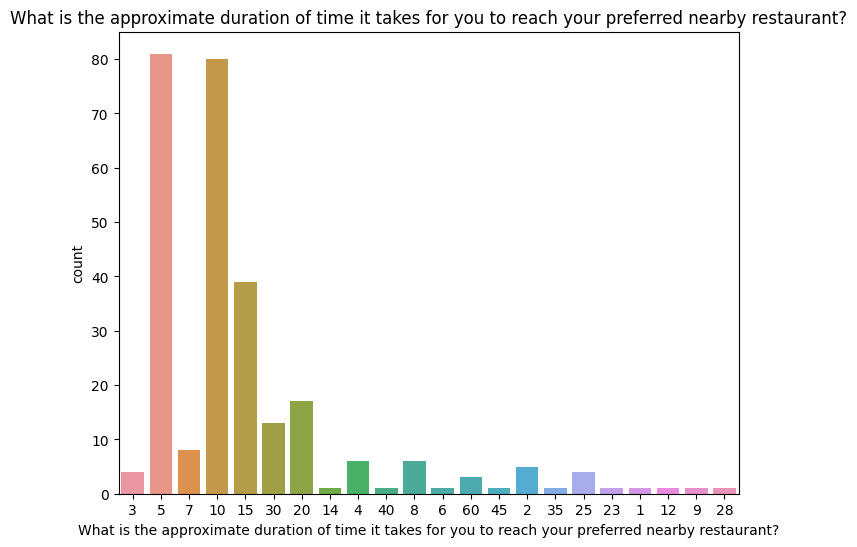

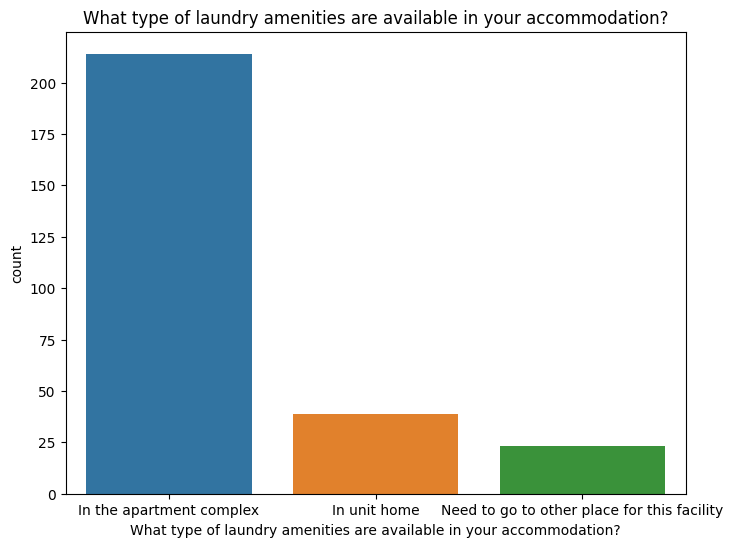

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

df = pd.read_csv("questionnaire responses - Sheet1.csv")

###################################################################################
#### Exploratory Analysis ahead of Data Wrangling for Classification Algorithm ####
####                (Includes some Data Wrangling as well)                     ####
###################################################################################

# Display the first few rows of the dataset
print(df.head())

# Check the shape of the dataset
print(df.shape)

# Check the data types of the columns
print(df.dtypes)

# Check the number of missing values in each column
print(df.isnull().sum())

# Check the descriptive statistics of the numerical columns
print(df.describe())

# Removing Special Characters #
df = df.replace({'\$': ''}, regex=True)
df = df.replace({',': ''}, regex=True)
df = df.replace({'USD': ''}, regex=True)
df = df.replace({'dollars': ''}, regex=True)
df = df.replace({'min': ''}, regex=True)
df = df.replace({'minutes': ''}, regex=True)
df = df.replace({'-': ''}, regex=True)
df = df.replace({'/': ''}, regex=True)

# Filter out records that should be numeric but contain a letter  #
cols_to_check = ['What is the total monthly rent of your unit?','What is the approximate total amount of monthly bills (electricity, parking, etc.,) not included in your rent?']
df = df[~df[cols_to_check].applymap(lambda x: isinstance(x, str) and bool(re.search('[a-zA-Z]', x))).any(axis=1)]
df["What is the total monthly rent of your unit?"] = df["What is the total monthly rent of your unit?"].astype(float)
df = df[df["What is the total monthly rent of your unit?"] >= 150]

# Dropping columns/rows that are not required or value added for Exploratory Data Analysis 
df = df[df["What is your WSU id?"].str.len() <= 8]
df.drop(["What is your WSU id?","Timestamp","What is your current address?"],inplace=True,axis=1)
df = df[df["How long have you been in Wichita? (in months)"] != 0]
df = df[df["This questionnaire helps the new international students coming to WSU. Do you want to fill this form?"] != 0]
df = df[df["Where are you living currently?"] != "House you own"]
df = df[df["If other, Please specify your apartment name."] != "KFC "]

# Drop columns where the percentage of null values is greater than 20% of total column values #
null_percentages = df.isnull().sum() / len(df)
df = df.drop(columns=null_percentages[null_percentages > 0.2].index)

# Force classes to look the same across certain feautres for easier dummy variable creation #
df = df.replace(to_replace= '3Bed 1.5 bath', value = '3 bed 1.5 bath')
df = df.replace(to_replace= '4bed 2bath', value = '4 bed 2 bath')
df = df.replace(to_replace= '3 BED 3 BATH', value = '3 bed 3 bath')
df = df.replace(to_replace= '3 bed 3bath', value = '3 bed 3 bath')

# Change the last column in the data frame to be simpler for an algorithm to consume #
def count_words(df, column_name):
    # create a new column that splits the original column into words
    df['words'] = df[column_name].str.split()
    # count the number of words in each value
    df['Number of Amenities Paid for by Rent'] = df['words'].apply(len)
    # drop the temporary 'words' column
    df = df.drop(columns=['words'])
    return df
df = count_words(df,"What are all the amenities that are included in your rent?")
df.drop("What are all the amenities that are included in your rent?",axis=1,inplace=True)

# Visualize the distribution of each numerical column using histograms
for column in df.select_dtypes(include=np.number):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df[column], kde=True)
    plt.title(column)
    plt.show()

# Visualize the correlation between the numerical columns using a heatmap
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

# Visualize the relationship between the numerical and categorical columns using boxplots
for column in df.select_dtypes(include=np.object):
    if len(df[column].unique()) <= 5:
        for numerical_column in df.select_dtypes(include=np.number):
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=column, y=numerical_column, data=df)
            plt.title(f"{column} vs {numerical_column}")
            plt.show()

# Visualize the frequency of each categorical column using countplots
for column in df.select_dtypes(include=np.object):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=df)
    plt.title(column)
    plt.show()

In [12]:
####################################################################
#### Data Wrangling in Preperation for Classification Algorithm ####
####################################################################

### Replacing binary answer choices with 1s and 0s ###
df = df.replace(to_replace= 'Yes', value = 1)
df = df.replace(to_replace= 'No', value = 0)
df = df.replace(to_replace= "Don't know", value = 0)
df = df.replace(to_replace= "Don't Know", value = 0)
# Adjusting Month data to be more realistic 
df["How long have you been in Wichita? (in months)"].fillna(0,inplace=True)
df["How long have you been in Wichita? (in months)"] = df["How long have you been in Wichita? (in months)"].astype(float)
df["How long have you been in Wichita? (in months)"].round()

### Change Data Types of All Columns to float or boolean (where there won't be an error) ###
def convert_to_float(df):
    # create an empty dataframe with the same column names as the input dataframe
    converted_df = pd.DataFrame(columns=df.columns)

    # iterate over the columns in the input dataframe
    for column in df.columns:
        if set(df[column].unique()) == {0, 1}:
            # if the column has only 0's and 1's, convert it to uint8
            converted_df[column] = df[column].astype('uint8')
        else:
            try:
                # try to convert the column to float
                converted_column = df[column].astype(float)
                converted_df[column] = converted_column
            except ValueError:
                # if there's an error and the column doesn't have only 0's and 1's, keep the original column type
                converted_df[column] = df[column]
    return converted_df
df = convert_to_float(df)

### Creating Dummy Variables for Multi Label Features ###
def create_dummy_variables(df):
    # create a new dataframe to store the dummy variables
    dummy_df = pd.DataFrame()
    
    # iterate over the columns in the input dataframe
    for column in df.columns:
        if df[column].dtype == 'object':
            # if the column is of object data type, create dummy variables using pandas' get_dummies() function
            dummy_variables = pd.get_dummies(df[column], prefix=column, drop_first=True)
            dummy_df = pd.concat([dummy_df, dummy_variables], axis=1)
        else:
            # if the column is not of object data type, simply add it to the new dataframe
            dummy_df[column] = df[column]
    
    return dummy_df
df = create_dummy_variables(df)

### Remove any outliers that may be left behind after above wrangling ###
def remove_outliers(df, columns, threshold=3):
    # calculate the z-score for each value in each specified column
    z_scores = df[columns].apply(lambda x: np.abs((x - x.mean()) / x.std()), axis=0)
    # create a boolean mask for each value that indicates whether it is an outlier
    mask = z_scores > threshold
    # replace outliers with NaN values
    df[mask] = np.nan
    # drop rows containing any NaN values
    df = df.dropna()
    return df
column_list = ["What is the total monthly rent of your unit?","What was the total amount you paid initially, covering fees such as application fees, deposit fees, and others?",
               "What is the approximate total amount of monthly bills (electricity, parking, etc.,) not included in your rent?",
               "What is the approximate duration of time, in minutes, it takes for you to reach your closest grocery store?",
               "What is the approximate duration of time it takes for you to reach your preferred nearby restaurant?","How long have you been in Wichita? (in months)"]
df = remove_outliers(df,column_list)

print("Final Shape of Data for Algorithm Consumption (Post Data Wrangling): ",df.shape)
df.to_csv('preped_data_for_algo.csv',index=False)

Final Shape of Data for Algorithm Consumption (Post Data Wrangling):  (246, 49)


In [14]:
####################################################################
####              Classification Algorithm & Results            ####
####################################################################

X = df.drop('Overall, how satisfied are you with your current living?', axis=1)
y = df['Overall, how satisfied are you with your current living?']

# Balance the dataset using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
X_res, y_res = oversample.fit_resample(X, y)

# Display the number of samples in each class after balancing
print(pd.Series(y_res).value_counts())

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier on the training set
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dtc.predict(X_test)

# Evaluate the model using classification report
print("Results for Decision Tree classifier:")
print(classification_report(y_test, y_pred))

# Create the model and fit it to the training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Print the classification report
print("Results for Random Forest classifier:")
print(classification_report(y_test, y_pred))

# Create the GBRF model
model = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Print the classification report
print("Results for Random Forest classifier (Gradient Boosted):")
print(classification_report(y_test, y_pred))

3.0    102
5.0    102
4.0    102
2.0    102
1.0    102
Name: Overall, how satisfied are you with your current living?, dtype: int64
Results for Decision Tree classifier:
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.98        20
         2.0       1.00      1.00      1.00        18
         3.0       0.81      0.77      0.79        22
         4.0       0.80      0.76      0.78        21
         5.0       0.73      0.76      0.74        21

    accuracy                           0.85       102
   macro avg       0.86      0.86      0.86       102
weighted avg       0.85      0.85      0.85       102

Results for Random Forest classifier:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        20
         2.0       1.00      1.00      1.00        18
         3.0       0.89      0.73      0.80        22
         4.0       0.79      0.90      0.84        21
         5.0       0.82      0.8